In [ ]:
import pandas as pd

from bengrn import get_GT_db, get_perturb_gt, get_sroy_gt, BenGRN, FILEDIR

from grnndata import read_h5ad
import numpy as np
import tqdm
import os

#! lamin init --storage ./lamin-intro --schema bionty

import scanpy as sc

from scprint import scPrint
from scprint.tasks import GNInfer
from scdataloader import Preprocessor

from bengrn import BenGRN
import scanpy as sc
from anndata.utils import make_index_unique

from bengrn.base import train_classifier
from bengrn import compute_genie3
from grnndata import utils as grnutils
import scipy.sparse

from scdataloader.utils import load_genes
import anndata as ad
import bionty as bt
from grnndata import from_adata_and_longform

import torch

torch.set_float32_matmul_precision("medium")

%load_ext autoreload
%autoreload 2

LOC = "/pasteur/appa/scratch/jkalfon/data/spcrint_data"  #

/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/ctxcore/__init__.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


→ connected lamindb: jkobject/scprint2


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [ ]:
import pandas as pd

from bengrn import get_GT_db, get_perturb_gt, get_sroy_gt, BenGRN, FILEDIR

from grnndata import read_h5ad
import numpy as np
import tqdm
import os

#! lamin init --storage ./lamin-intro --schema bionty

import scanpy as sc

from scprint import scPrint
from scprint.tasks import GNInfer
from scdataloader import Preprocessor

from bengrn import BenGRN
import scanpy as sc
from anndata.utils import make_index_unique

from bengrn.base import train_classifier
from bengrn import compute_genie3
from grnndata import utils as grnutils
import scipy.sparse

from scdataloader.utils import load_genes
import anndata as ad
import bionty as bt
from grnndata import from_adata_and_longform

import torch

torch.set_float32_matmul_precision("medium")

%load_ext autoreload
%autoreload 2

LOC = "/pasteur/appa/scratch/jkalfon/data/spcrint_data"  #

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# J comparison of gene networks from human interactome, cellmaps, omnipath,


In [ ]:
! wget --no-check-certificate -O $LOC/RF2-PPI.gz https://conglab.swmed.edu/humanPPI/downloads/RF2-PPI_scores.gz
! wget --no-check-certificate -O $LOC/DCA_scores.gz https://conglab.swmed.edu/humanPPI/downloads/DCA_scores.gz
! wget --no-check-certificate -O $LOC/AF_scores.gz https://conglab.swmed.edu/humanPPI/downloads/AF_scores.gz

--2025-11-12 23:10:51--  https://conglab.swmed.edu/humanPPI/downloads/RF2-PPI_scores.gz


Resolving maestro-squid.maestro.pasteur.fr (maestro-squid.maestro.pasteur.fr)... 192.168.148.66
Connecting to maestro-squid.maestro.pasteur.fr (maestro-squid.maestro.pasteur.fr)|192.168.148.66|:3128... connected.


Proxy request sent, awaiting response... 

200 OK
Length: 443540479 (423M) [application/x-gzip]
Saving to: ‘/pasteur/appa/scratch/jkalfon/data/spcrint_data/RF2-PPI.gz’


          /pasteur/   0%[                    ]       0  --.-KB/s               


         /pasteur/a   0%[                    ]  46.78K   191KB/s               


        /pasteur/ap   0%[                    ] 210.84K   431KB/s               


       /pasteur/app   0%[                    ] 867.09K  1.15MB/s               


      /pasteur/appa   0%[                    ]   3.42M  3.50MB/s               


     /pasteur/appa/   2%[                    ]   9.36M  7.90MB/s               


    /pasteur/appa/s   3%[                    ]  15.29M  11.0MB/s               


   /pasteur/appa/sc   4%[                    ]  18.32M  11.5MB/s               


  /pasteur/appa/scr   5%[>                   ]  24.16M  13.1MB/s               


 /pasteur/appa/scra   7%[>                   ]  30.14M  14.4MB/s               


/pasteur/appa/scrat   8%[>                   ]  35.99M  15.4MB/s               


pasteur/appa/scratc   9%[>                   ]  41.93M  16.2MB/s               


asteur/appa/scratch  11%[=>                  ]  47.77M  16.8MB/s               


steur/appa/scratch/  12%[=>                  ]  53.69M  17.4MB/s    eta 21s    


teur/appa/scratch/j  14%[=>                  ]  59.55M  17.9MB/s    eta 21s    


eur/appa/scratch/jk  15%[==>                 ]  65.41M  18.3MB/s    eta 21s    


ur/appa/scratch/jka  16%[==>                 ]  71.32M  18.6MB/s    eta 21s    


r/appa/scratch/jkal  18%[==>                 ]  77.24M  20.1MB/s    eta 18s    


/appa/scratch/jkalf  19%[==>                 ]  83.17M  22.4MB/s    eta 18s    


appa/scratch/jkalfo  21%[===>                ]  89.04M  23.5MB/s    eta 18s    


ppa/scratch/jkalfon  22%[===>                ]  94.95M  23.3MB/s    eta 18s    


pa/scratch/jkalfon/  23%[===>                ] 100.78M  23.8MB/s    eta 16s    


a/scratch/jkalfon/d  25%[====>               ] 106.76M  23.4MB/s    eta 16s    


/scratch/jkalfon/da  26%[====>               ] 112.53M  23.8MB/s    eta 16s    


scratch/jkalfon/dat  28%[====>               ] 118.48M  23.8MB/s    eta 16s    


cratch/jkalfon/data  29%[====>               ] 124.30M  23.4MB/s    eta 15s    


ratch/jkalfon/data/  30%[=====>              ] 130.28M  23.8MB/s    eta 15s    


atch/jkalfon/data/s  32%[=====>              ] 136.09M  23.8MB/s    eta 15s    


tch/jkalfon/data/sp  33%[=====>              ] 142.06M  23.4MB/s    eta 15s    


ch/jkalfon/data/spc  34%[=====>              ] 147.93M  23.8MB/s    eta 13s    


h/jkalfon/data/spcr  36%[======>             ] 153.88M  23.8MB/s    eta 13s    


/jkalfon/data/spcri  37%[======>             ] 159.74M  23.4MB/s    eta 13s    


jkalfon/data/spcrin  39%[======>             ] 165.66M  23.8MB/s    eta 13s    


kalfon/data/spcrint  40%[=======>            ] 171.46M  23.7MB/s    eta 12s    


alfon/data/spcrint_  41%[=======>            ] 177.44M  23.4MB/s    eta 12s    


lfon/data/spcrint_d  43%[=======>            ] 183.22M  23.8MB/s    eta 12s    


fon/data/spcrint_da  44%[=======>            ] 189.20M  23.8MB/s    eta 12s    


on/data/spcrint_dat  46%[========>           ] 194.98M  23.4MB/s    eta 11s    


n/data/spcrint_data  47%[========>           ] 200.95M  23.3MB/s    eta 11s    


/data/spcrint_data/  48%[========>           ] 206.79M  23.7MB/s    eta 11s    


data/spcrint_data/R  50%[=========>          ] 212.41M  23.3MB/s    eta 11s    


ata/spcrint_data/RF  51%[=========>          ] 218.34M  23.3MB/s    eta 11s    


ta/spcrint_data/RF2  52%[=========>          ] 224.17M  23.7MB/s    eta 9s     


a/spcrint_data/RF2-  54%[=========>          ] 230.16M  23.7MB/s    eta 9s     


/spcrint_data/RF2-P  55%[==========>         ] 236.11M  23.3MB/s    eta 9s     


spcrint_data/RF2-PP  57%[==========>         ] 241.96M  23.7MB/s    eta 9s     


pcrint_data/RF2-PPI  58%[==========>         ] 247.92M  23.7MB/s    eta 8s     


crint_data/RF2-PPI.  59%[==========>         ] 253.76M  23.3MB/s    eta 8s     


rint_data/RF2-PPI.g  61%[===========>        ] 259.72M  23.4MB/s    eta 8s     


int_data/RF2-PPI.gz  62%[===========>        ] 265.58M  23.8MB/s    eta 8s     


nt_data/RF2-PPI.gz   64%[===========>        ] 271.47M  23.3MB/s    eta 7s     


t_data/RF2-PPI.gz    65%[============>       ] 277.34M  23.3MB/s    eta 7s     


_data/RF2-PPI.gz     66%[============>       ] 283.25M  23.4MB/s    eta 7s     


data/RF2-PPI.gz      68%[============>       ] 289.12M  23.7MB/s    eta 7s     


ata/RF2-PPI.gz       69%[============>       ] 295.00M  23.8MB/s    eta 6s     


ta/RF2-PPI.gz        71%[=============>      ] 300.95M  23.4MB/s    eta 6s     


a/RF2-PPI.gz         72%[=============>      ] 306.82M  23.5MB/s    eta 6s     


/RF2-PPI.gz          73%[=============>      ] 312.76M  23.3MB/s    eta 6s     


RF2-PPI.gz           75%[==============>     ] 318.64M  23.8MB/s    eta 5s     


F2-PPI.gz            76%[==============>     ] 324.51M  23.8MB/s    eta 5s     


2-PPI.gz             78%[==============>     ] 330.41M  23.3MB/s    eta 5s     


-PPI.gz              79%[==============>     ] 336.30M  23.4MB/s    eta 5s     


PPI.gz               80%[===============>    ] 342.24M  23.3MB/s    eta 4s     


PI.gz                82%[===============>    ] 348.14M  23.8MB/s    eta 4s     


I.gz                 83%[===============>    ] 354.07M  23.4MB/s    eta 4s     


.gz                  85%[================>   ] 359.92M  23.3MB/s    eta 4s     


gz                   86%[================>   ] 365.86M  23.8MB/s    eta 3s     


z                    87%[================>   ] 371.69M  23.4MB/s    eta 3s     


                     89%[================>   ] 377.65M  23.4MB/s    eta 3s     


                  /  90%[=================>  ] 383.42M  23.8MB/s    eta 3s     


                 /p  92%[=================>  ] 389.35M  24.1MB/s    eta 3s     


                /pa  93%[=================>  ] 394.23M  23.7MB/s    eta 1s     


               /pas  94%[=================>  ] 398.15M  23.4MB/s    eta 1s     


              /past  95%[==================> ] 404.01M  23.8MB/s    eta 1s     

In [1]:
res = pd.read_csv(
    LOC + "/RF2-PPI.gz",
    sep="\t",
    skiprows=7,
    header=None,  # nrows=100_000_000
)
res.columns = ["Pair", "RF2-PPI_interaction_probability", "Source"]

NameError: name 'pd' is not defined

In [ ]:
import bionty as bt

In [ ]:
sns.histplot(res["RF2-PPI_interaction_probability"])

In [ ]:
prot_to_gene = {
    i["uniprotkb_id"]: i["gene_symbol"] for k, i in bt.Protein.public().df().iterrows()
}
genes = []
for i in res.Pair:
    a, b = i.split("_")
    genes.append([prot_to_gene.get(a, ""), prot_to_gene.get(b, "")])

res[["geneA", "geneB"]] = genes

In [ ]:
res = res[~res["geneA"].isna() & ~res["geneB"].isna()]

In [ ]:
res.to_parquet(LOC + "/RF2-PPI.parquet")

In [ ]:
res = pd.read_parquet(LOC + "/RF2-PPI.parquet")

In [3]:
THRESHOLD = 0.4

In [ ]:
humaninter_s = set(
    res[res["RF2-PPI_interaction_probability"] > THRESHOLD]["geneA"]
    .str.cat(res[res["RF2-PPI_interaction_probability"] > THRESHOLD]["geneB"], sep="_")
    .tolist()
)

In [5]:
len(humaninter_s)

765411

In [6]:
gwps = get_perturb_gt()
gwps.var.index = gwps.var.gene_name
gwps = gwps.extract_links()

In [7]:
omni = get_GT_db("omnipath")
collectri = get_GT_db("collectri")

In [8]:
omni_s = set([s + "_" + t for s, t in omni.iloc[:, :2].values])
collectri_s = set([s + "_" + t for s, t in collectri.iloc[:, :2].values])
gwps_s = set([s + "_" + t for s, t in gwps.iloc[:, :2].values])

In [3]:
# getting U2OS cell map data
import json

try:
    import ndex2
except ImportError:
    os.system("uv pip install ndex2")
    import ndex2
from ndex2.cx2 import RawCX2NetworkFactory, CX2NetworkXFactory
from ndex2.cx2 import CX2NetworkPandasDataFrameFactory

# Create NDEx2 python client
client = ndex2.client.Ndex2()

# Create CX2Network factory
factory = RawCX2NetworkFactory()

client_resp = client.get_network_as_cx2_stream("95bc75d5-d1d1-11ee-8a40-005056ae23aa")

# Convert downloaded network to CX2Network object
net_cx = factory.get_cx2network(json.loads(client_resp.content))

# Display information about network and output 1st 100 characters of CX2
print("Name: " + net_cx.get_name())
print("Number of nodes: " + str(len(net_cx.get_nodes())))
print("Number of edges: " + str(len(net_cx.get_edges())))

# Creating an instance of CX2NetworkPandasDataFrameFactory
factory = CX2NetworkPandasDataFrameFactory()

# Converting CX2Network to DataFrame
cellmap = factory.get_dataframe(net_cx)

Name: U2OS AP-MS network
Number of nodes: 7543
Number of edges: 36842


In [10]:
cellmap_s = set([s + "_" + t for s, t in cellmap.iloc[:, [2, 4]].values])

In [11]:
print("number of edges in gwps: ", len(gwps_s))
print("number of edges in omni: ", len(omni_s))
print("number of edges in collectri: ", len(collectri_s))
print("number of edges in humaninter: ", len(humaninter_s))
print("number of edges in cellmap: ", len(cellmap_s))

number of edges in gwps:  1115036
number of edges in omni:  273556
number of edges in collectri:  41595
number of edges in humaninter:  765411
number of edges in cellmap:  36842


In [14]:
cellmap_s

{'ASPH_SLC38A1',
 'NEMP1_GLRB',
 'WASHC3_ATP6V0D1',
 'EFNB2_USP32',
 'ERAP1_UBTF',
 'ZFPL1_RAB3GAP1',
 'SPINT2_OSMR',
 'VENTX_PON2',
 'VENTX_PGLS',
 'CLGN_JMJD8',
 'FGL1_LIMCH1',
 'ZNF346_YTHDC1',
 'CHRM4_SLC25A24',
 'CD40_SMG8',
 'LPAR1_ACSL4',
 'CTSV_LRRC15',
 'LRRC49_SANBR',
 'MRPS23_GYS1',
 'PTPN4_SVIL',
 'NEUROG3_RBM23',
 'VENTX_PPCS',
 'FOSL2_C1D',
 'BBS1_BBS5',
 'SNAP91_BRCA1',
 'CDC20_SKP2',
 'TMEM31_UCHL5',
 'PYCR3_BCL7C',
 'ITM2C_CYRIB',
 'NIPAL1_TRPM4',
 'HTR2C_TBC1D15',
 'TTC9C_USO1',
 'GAB2_PLS3',
 'BRK1_ABI3',
 'SPSB2_USP11',
 'ANKRD46_ATRN',
 'EGFL8_EGFL7',
 'SURF6_SCAF8',
 'UCHL5_INO80C',
 'MED17_MED9',
 'PSG3_TMEM214',
 'FBXO6_IGF1R',
 'IGF2BP3_MRPL10',
 'CTSV_CTSL',
 'RBMX2_SPOUT1',
 'CCT7_TXNDC9',
 'CTNNBIP1_CTNNA2',
 'LPAR1_EXOC6B',
 'NDUFC2_NDUFB1',
 'GPR12_ATL3',
 'TLE2_CCT5',
 'CCT7_KLHDC8B',
 'S1PR3_NIBAN2',
 'GPR17_ECHDC1',
 'PSMA5_PSMB7',
 'PLOD3_VPS33B',
 'YWHAB_RAI14',
 'LPAR1_SKP2',
 'ANAPC5_CDC27',
 'ACVR1_MED24',
 'KCTD17_EGFL7',
 'SLC2A12_ACY1',
 'FOSL2_

In [13]:
gwps_s

{'CAD_TAF2',
 'ZNF670_KRR1',
 'TCEA1_PMPCA',
 'PPP1R12A_CNOT9',
 'KDM6A_MED19',
 'RBM14_ERCC2',
 'KIF5B_RPS27',
 'ERP44_MED29',
 'NUP155_GRPEL1',
 'RPLP1_ESYT1',
 'RPS19_HSPD1',
 'SESN2_NELFE',
 'MEF2C_WDR61',
 'SNHG32_ZNRD1',
 'MICOS10_CCT7',
 'RPL35A_POP5',
 'PRELID1_PPIH',
 'IER3IP1_INTS7',
 'CD53_UHRF1',
 'SLC25A5_NUP54',
 'ANKRD28_SETX',
 'FBL_INTS2',
 'GNL3L_GPS1',
 'PRPF8_CCDC6',
 'RPS23_DIS3',
 'PRDX1_RUVBL1',
 'CTAG2_PRKCA',
 'ANKRD11_VARS',
 'ZDHHC3_ADSL',
 'TPR_TYK2',
 'TMEM147_TBL3',
 'RPLP0_DDX3X',
 'ATXN7L3B_RIOK2',
 'NORAD_GPS1',
 'EEF2_GFER',
 'UBE2H_DDX24',
 'RPS6_TNIP1',
 'PYURF_NUP133',
 'CKS1B_TAF1C',
 'C1orf35_RPL36',
 'TIMMDC1_ADAL',
 'EXPH5_PTPN1',
 'PFDN5_NOP16',
 'FAM49B_VPS29',
 'POLR1D_PMPCB',
 'C11orf58_MED22',
 'MRPL51_TTC4',
 'CNOT10_ITGB1BP1',
 'SRP19_RRS1',
 'MARCKSL1_DOHH',
 'MFAP1_WDR76',
 'RHOC_DNAJC19',
 'SEC61G_POLR2B',
 'F11R_ZDHHC7',
 'TXNRD2_MAX',
 'RPL32_UBE3D',
 'TPM4_SMC1A',
 'RPL10A_LUC7L3',
 'FAM49B_MAX',
 'ACAA1_RPTOR',
 'HMGN2_INTS2',
 'MT

In [12]:
humaninter_s

{'RB1CC1_MARCHF2',
 'SLC7A13_B3GALT1',
 'PDHA1_PDHB',
 'ALG10B_TMEM69',
 'CD2BP2_STK40',
 'IGHV2-70_IGKV1-13',
 'UNC5C_TMEM138',
 'HNRNPA0_ZNF580',
 'EPHA4_FRZB',
 'REXO1L1P_ANKRD52',
 'GNMT_DOHH',
 'CCNA1_CWC27',
 'OR4A8_PCDHGC4',
 'RP2_RUSF1',
 'KNOP1_POLDIP3',
 'MCU_MYO5C',
 'GOLGA2_PTK7',
 'YWHAB_KCNK4',
 'IGLV3-25_IGHV3-53',
 'SNRPGP15_CUL4A',
 'TLR2_DOHH',
 'BHLHA15_ASCL3',
 'OR2A42_HACD3',
 'DEF8_LRIG1',
 'TAF11L2_CDK9',
 'WDR77_SCML2',
 'CIAO1_TWF2',
 'RABGGTB_GMFB',
 'AKR7A3_CCT5',
 'SSU72L5_STK17B',
 'LRG1_RCN1',
 'PARD6G_EIF2B3',
 'SUPV3L1_DPH7',
 'FNIP1_SLC38A7',
 'RPL3_DDX25',
 'MYO1B_PPIL3',
 'SDCBP2_NOC2L',
 'PRP4K_ANGEL2',
 'DTYMK_ADRA1B',
 'TMEM198_LRTM2',
 'BPGM_RPH3A',
 'STK11_PRMT6',
 'CFHR3_FCN2',
 'COX10_TMEM201',
 'DGKE_SVIP',
 'CXorf66_TMEM123',
 'CLUAP1_CEP19',
 'SMN1; SMN2_ISG20',
 'SAMD5_ELMOD2',
 'RNF4_NGB',
 'OR51D1_OR1L6',
 'MT-CO2_ANKIB1',
 'PHYHD1_TMEM186',
 'MORN5_ADGRE2',
 'KDM1A_SCRT1',
 'TTC36_TPST2',
 'MIXL1_RBM8A',
 'EVPLL_DPEP2',
 'TM7SF2_AADAC',


In [ ]:
! uv pip install venn

<Axes: >

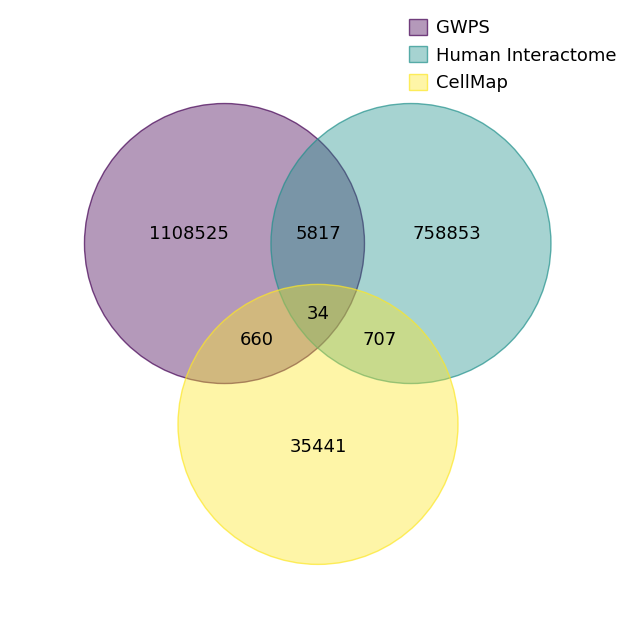

In [15]:
from venn import venn

# Create a dictionary of sets
sets = {
    #'OmniPath': omni,
    #'CollecTRI': collectri,
    "GWPS": gwps_s,
    "Human Interactome": humaninter_s,
    "CellMap": cellmap_s,
}

venn(sets)

In [15]:
sets = {
    "OmniPath": omni_s,
    "CollecTRI": collectri_s,
    "GWPS": gwps_s,
    "Human Interactome": humaninter_s,
    "CellMap": cellmap_s,
}

venn(sets)

NameError: name 'omni_s' is not defined

<Axes: >

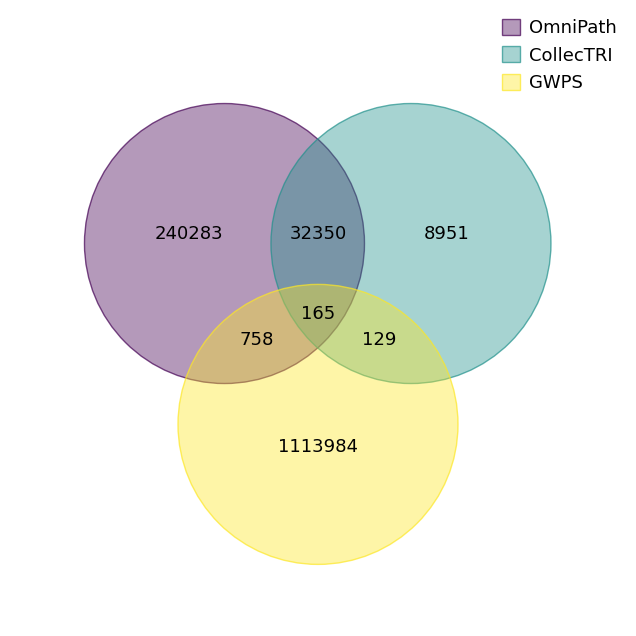

In [ ]:
sets = {
    "OmniPath": omni_s,
    "CollecTRI": collectri_s,
    "GWPS": gwps_s,
    #'Human Interactome': humaninter,
    #'CellMap': cellmap
}

venn(sets)

In [ ]:
del res

In [ ]:
# Load gene names
genes = load_genes("NCBITaxon:9606")

# Create empty anndata with gene names
empty_adata = ad.AnnData(X=np.zeros((1, len(genes))), var=genes)
print(f"Created empty AnnData with {len(genes)} genes")
empty_adata.var["ensembl_id"] = empty_adata.var.index
empty_adata.var.set_index("symbol", inplace=True, drop=False)
gt_cm = from_adata_and_longform(empty_adata, cellmap.iloc[:, [2, 4]])
gt_cm = gt_cm[:, (gt_cm.varp["GRN"].sum(1) != 0) | (gt_cm.varp["GRN"].sum(0) != 0)]
gt_cm.varp["GRN"] = scipy.sparse.csr_matrix(gt_cm.varp["GRN"].astype(np.float32))
gt_cm.varp["GRN"] = scipy.sparse.csr_matrix(gt_cm.varp["GRN"].astype(np.float32))

gt_inter = from_adata_and_longform(
    empty_adata,
    res[res["RF2-PPI_interaction_probability"] > THRESHOLD][
        ["geneA", "geneB", "RF2-PPI_interaction_probability"]
    ],
    has_weight=True,
)


gt_cm.var.index.name = "index"
gt_inter.var.index.name = "index"

In [ ]:
gt_cm.write_h5ad(LOC + "/gt_cellmap.h5ad")
gt_inter.write_h5ad(LOC + "/gt_humaninter.h5ad")

## predict human interactome network


In [36]:
model_checkpoint_file = "../models/ogvvg2z7-v1.ckpt"
# "../models/ogvvg2z7-v1.ckpt"
# "../models/ji9krimq.ckpt"
# w937u4o1.ckpt"

In [37]:
model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)
model = model.to("cuda")

FYI: scPrint is not attached to a `Trainer`.


In [3]:
gt_cm = read_h5ad(LOC + "/gt_cellmap.h5ad")
gt_inter = read_h5ad(LOC + "/gt_humaninter.h5ad")

In [ ]:
LOC = "/pasteur/appa/scratch/jkalfon/data/"

In [ ]:
adata = sc.read(LOC + "/task4_human_preprocessed.h5ad")
# mouse = sc.read(LOC+"/task4_mouse_preprocessed.h5ad")

In [10]:
adata

View of AnnData object with n_obs × n_vars = 31172 × 20971
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'n_genes', 'n_counts', 'sample', 'stage', 'celltype', 'batch', 'organism_ontology_term_id'
    var: 'n_cells'
    uns: 'log1p'

In [ ]:
adata = adata[(adata.X.sum(1) > 500)]
adata = adata[
    adata.obs.celltype.isin(
        [k for k, v in adata.obs.celltype.value_counts().items() if v > 1000]
    )
]
adata.obs.celltype.value_counts()

celltype
Loop of Henle                  5985
Epithelial cell                3751
Intercalated cell              3416
Endothelial cell (APC)         2676
Monocyte                       2361
Macrophage                     2157
Smooth muscle cell             2156
Dendritic cell                 1828
Sinusoidal endothelial cell    1244
Name: count, dtype: int64

In [15]:
gwps = get_perturb_gt()
gwps.var.index = gwps.var.gene_name

  0%|          | 0.00/9.93G [00:00<?, ?B/s]

In [16]:
gt_inter_high_qual = gt_inter.copy()
gt_inter_high_qual.varp["GRN"] = (gt_inter_high_qual.varp["GRN"] > 0.7).astype(
    np.float32
)

In [17]:
model.mask_zeros = True

number of expressed genes in this cell type: 15492


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


predict epoch start


100%|██████████| 64/64 [00:03<00:00, 16.38it/s]


avg link count: 13749264, sparsity: 1.0
loading GT,  collectri
intersection of 1836 genes
intersection pct: 0.4962162162162162
only tf:  False
using only tf:  0.4962162162162162
total true edges:  5512.0
precision:  0.0016351735562295604 
recall:  1.0 
random precision: 0.0016360646589849987


 86%|████████▌ | 110/128 [00:00<00:00, 215.91it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 215.68it/s]


Average Precision (AP):  0.0022256980810455725
Area Under Precision-Recall Curve (AUPRC):  0.0022197900302843732
EPR: 0.3326684252434588


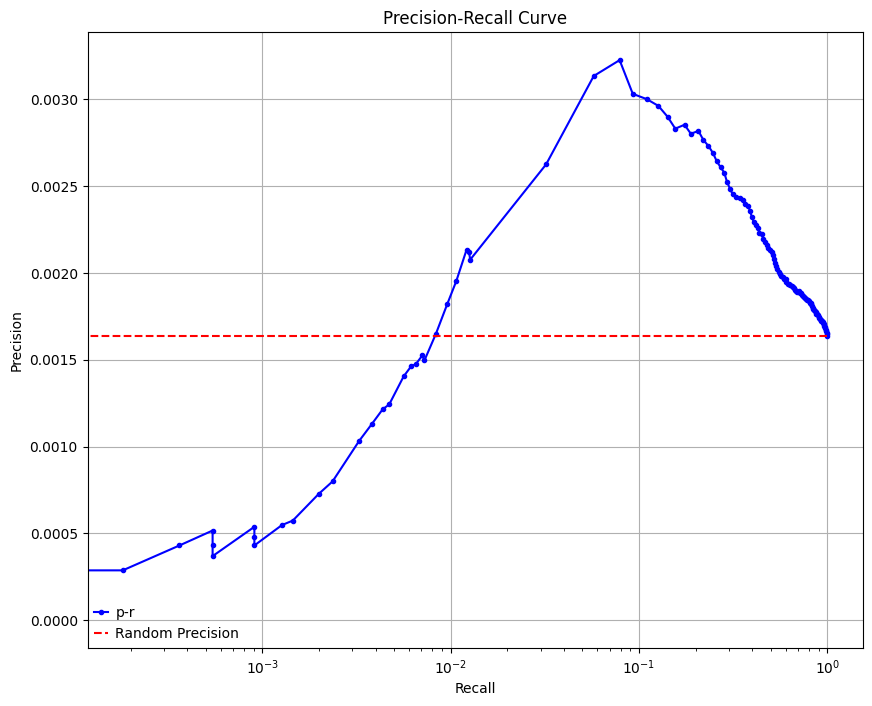

loading GT,  omnipath
intersection of 2683 genes
intersection pct: 0.7251351351351352
only tf:  False
using only tf:  0.7251351351351352
total true edges:  14135.0
precision:  0.001963606529092425 
recall:  1.0 
random precision: 0.001964338671720722


 94%|█████████▍| 120/128 [00:01<00:00, 91.30it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 91.25it/s]


Average Precision (AP):  0.003003267941393817
Area Under Precision-Recall Curve (AUPRC):  0.002999505803702939
EPR: 1.0084302200382411


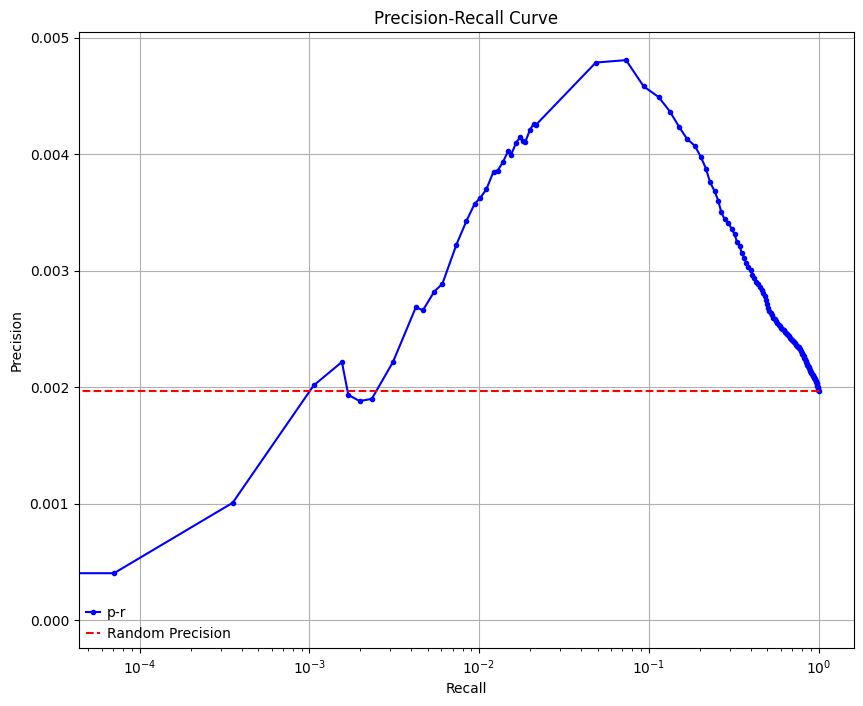

precision:  0.002768556216724084 
recall:  1.0 
random precision: 0.0027703435351338476


 93%|█████████▎| 119/128 [00:00<00:00, 1189.15it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1180.20it/s]


Average Precision (AP):  0.002998483556081243
Area Under Precision-Recall Curve (AUPRC):  0.00299428343667702
No true positives found. Returning EPR as 0.
EPR: 0.0


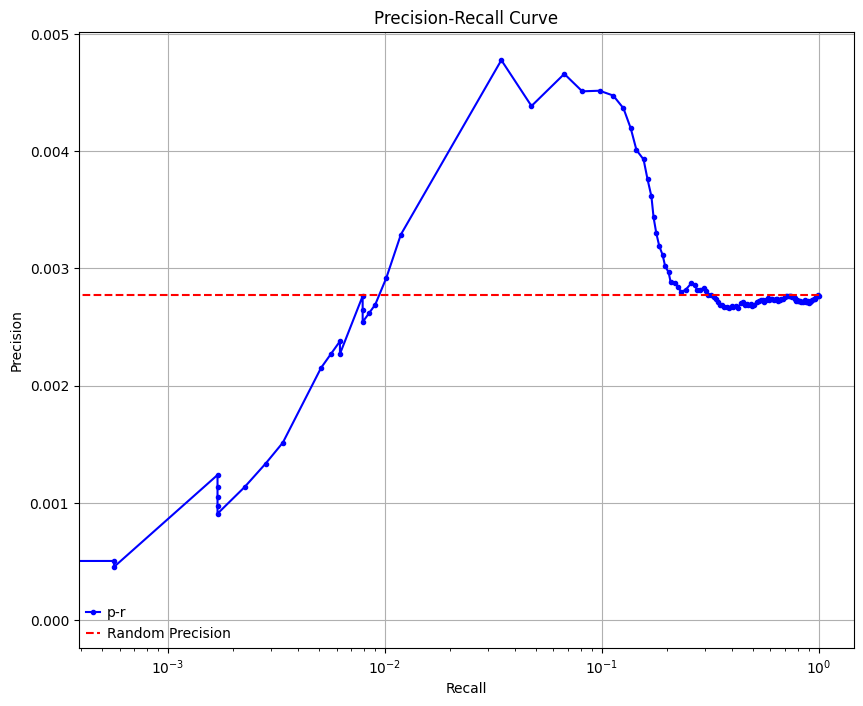

precision:  0.002768556216724084 
recall:  1.0 
random precision: 0.0027703435351338476


 93%|█████████▎| 119/128 [00:00<00:00, 1187.74it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1179.98it/s]


Average Precision (AP):  0.002998483556081243
Area Under Precision-Recall Curve (AUPRC):  0.00299428343667702
No true positives found. Returning EPR as 0.
EPR: 0.0


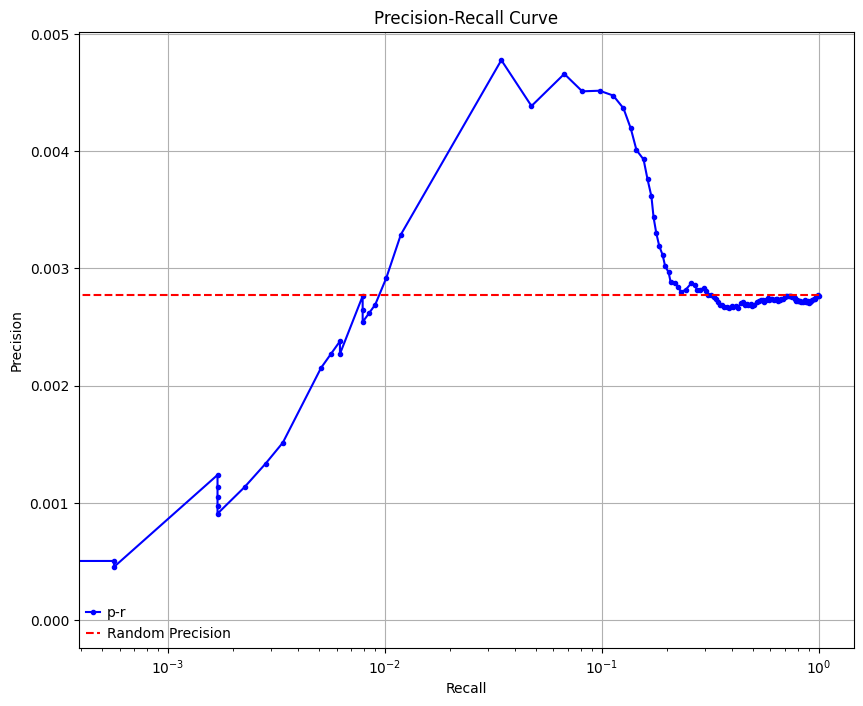

precision:  0.002988486995568852 
recall:  1.0 
random precision: 0.00298950626125629


 98%|█████████▊| 126/128 [00:01<00:00, 67.26it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 67.25it/s]


Average Precision (AP):  0.0035781896041834228
Area Under Precision-Recall Curve (AUPRC):  0.0035738090156042885
EPR: 2.7850104144140593


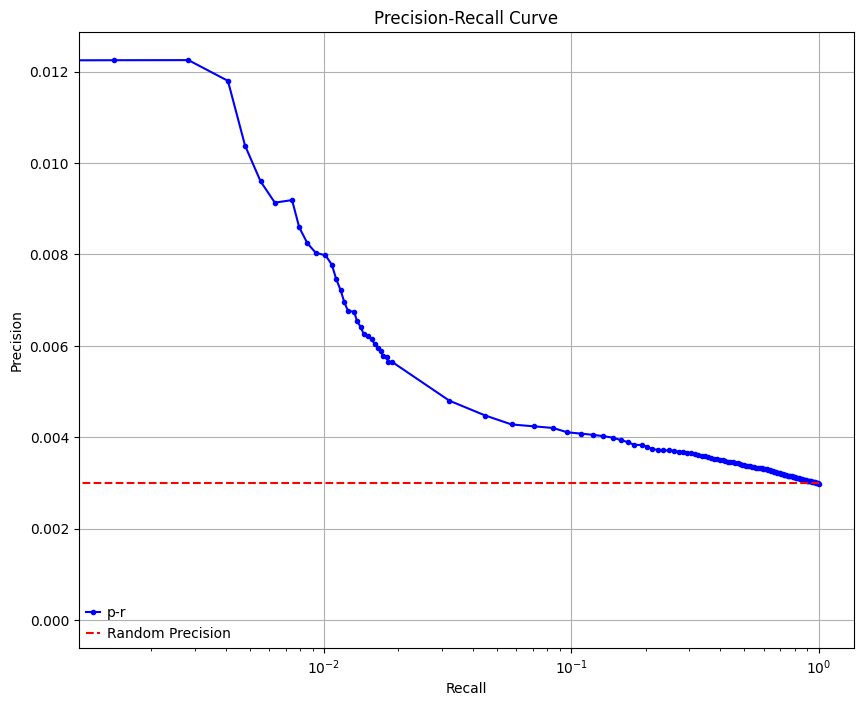

precision:  0.0005347732521561882 
recall:  1.0 
random precision: 0.0005349556441248636


 94%|█████████▍| 120/128 [00:01<00:00, 112.90it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 113.07it/s]


Average Precision (AP):  0.0008293163777116502
Area Under Precision-Recall Curve (AUPRC):  0.0008289610125244967
EPR: 7.243242974318198


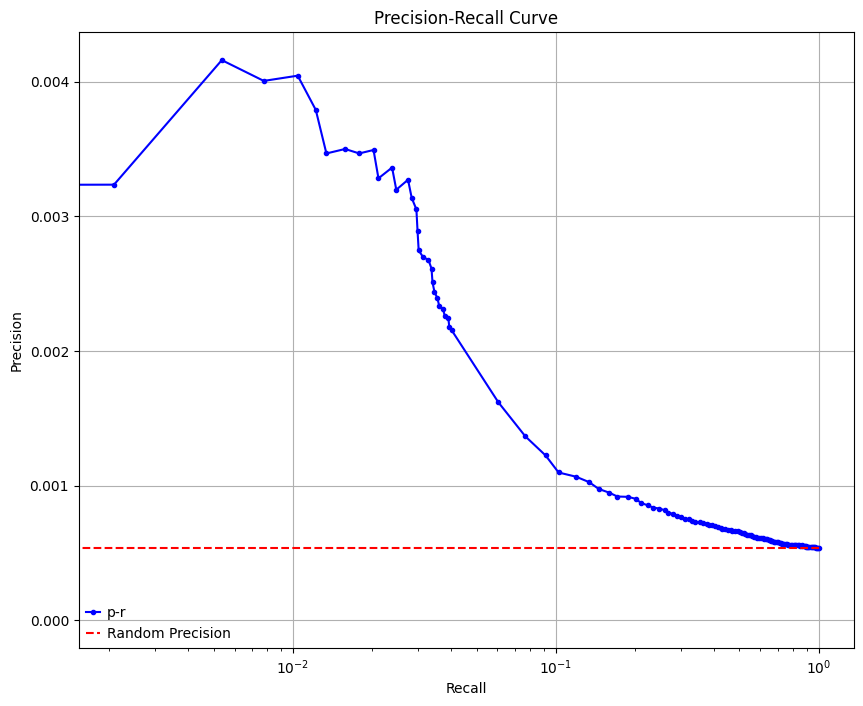

number of expressed genes in this cell type: 15002


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


predict epoch start


100%|██████████| 64/64 [00:03<00:00, 16.43it/s]


avg link count: 14160169, sparsity: 1.0
loading GT,  collectri
intersection of 1803 genes
intersection pct: 0.48015978695073236
only tf:  False
using only tf:  0.48015978695073236
total true edges:  4651.0
precision:  0.0014307207836572373 
recall:  1.0 
random precision: 0.0014315147463562702


 90%|████████▉ | 115/128 [00:00<00:00, 221.02it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 220.96it/s]


Average Precision (AP):  0.0018912488079074969
Area Under Precision-Recall Curve (AUPRC):  0.0018889158318145657
No true positives found. Returning EPR as 0.
EPR: 0.0


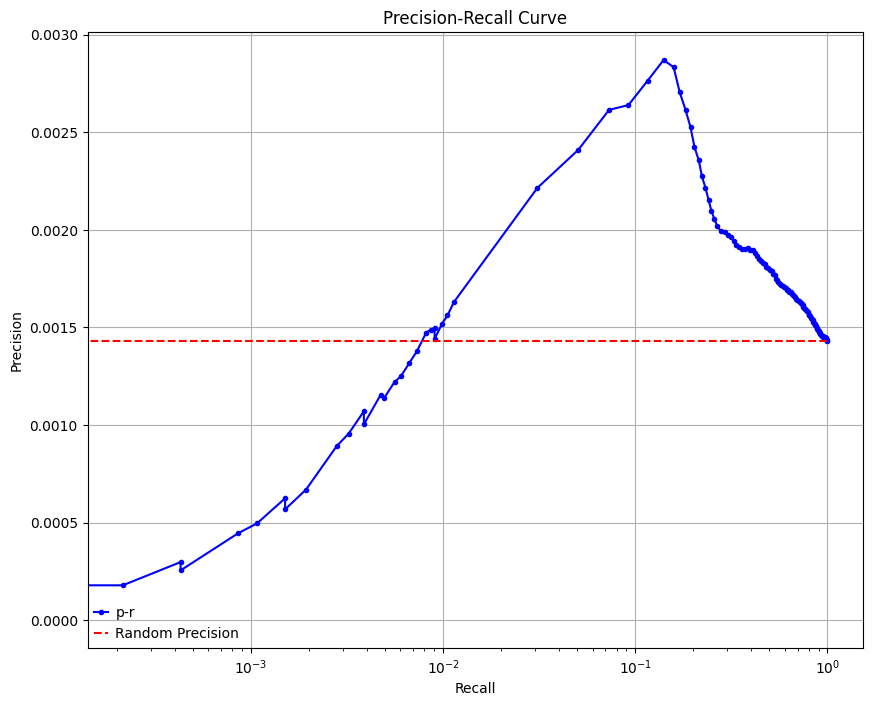

loading GT,  omnipath
intersection of 2667 genes
intersection pct: 0.7102529960053262
only tf:  False
using only tf:  0.7102529960053262
total true edges:  11057.0
precision:  0.0015545019752171024 
recall:  1.0 
random precision: 0.0015550850592288116


 94%|█████████▍| 120/128 [00:01<00:00, 95.62it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 95.67it/s]


Average Precision (AP):  0.002536731886220471
Area Under Precision-Recall Curve (AUPRC):  0.002529945576219922
EPR: 1.1631575318695417


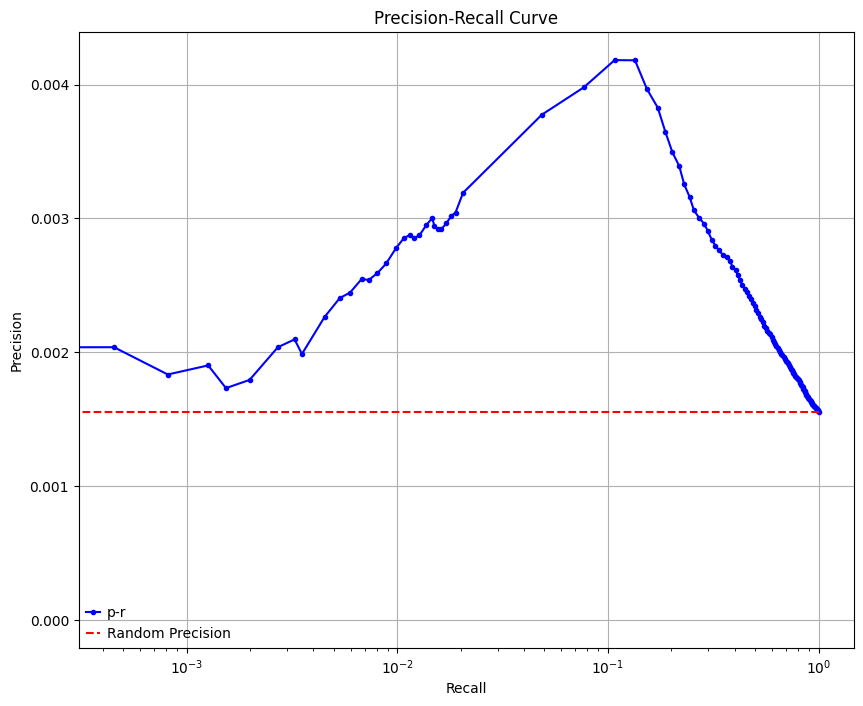

precision:  0.0025700488783087618 
recall:  1.0 
random precision: 0.0025714878754410737


 77%|███████▋  | 99/128 [00:00<00:00, 982.18it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 977.56it/s]


Average Precision (AP):  0.0029517818138190786
Area Under Precision-Recall Curve (AUPRC):  0.002938111306394351
EPR: 0.5812853815829946


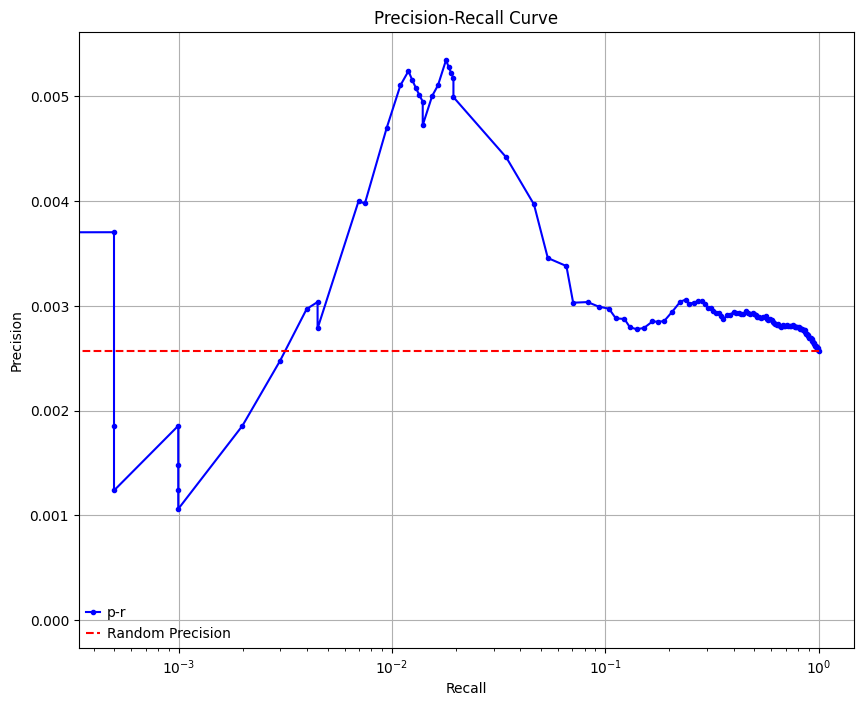

precision:  0.0025700488783087618 
recall:  1.0 
random precision: 0.0025714878754410737


 77%|███████▋  | 99/128 [00:00<00:00, 988.24it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 983.77it/s]


Average Precision (AP):  0.0029517818138190786
Area Under Precision-Recall Curve (AUPRC):  0.002938111306394351
EPR: 0.5812853815829946


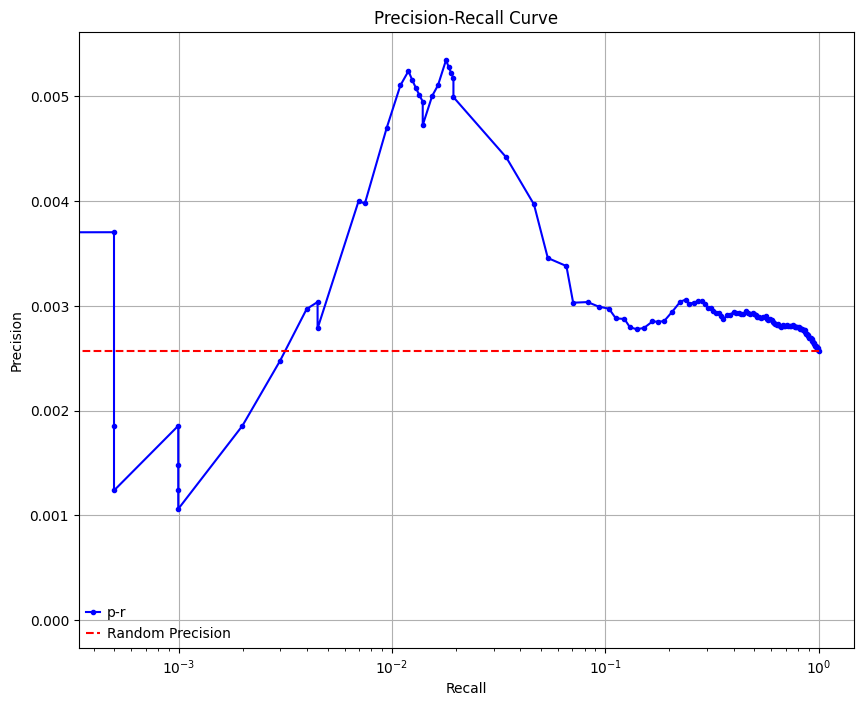

precision:  0.003325516866811766 
recall:  1.0 
random precision: 0.0033266205896351356


 98%|█████████▊| 126/128 [00:02<00:00, 62.49it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 62.44it/s]


Average Precision (AP):  0.003777126860922326
Area Under Precision-Recall Curve (AUPRC):  0.0037613901295581956
EPR: 2.3703720934135766


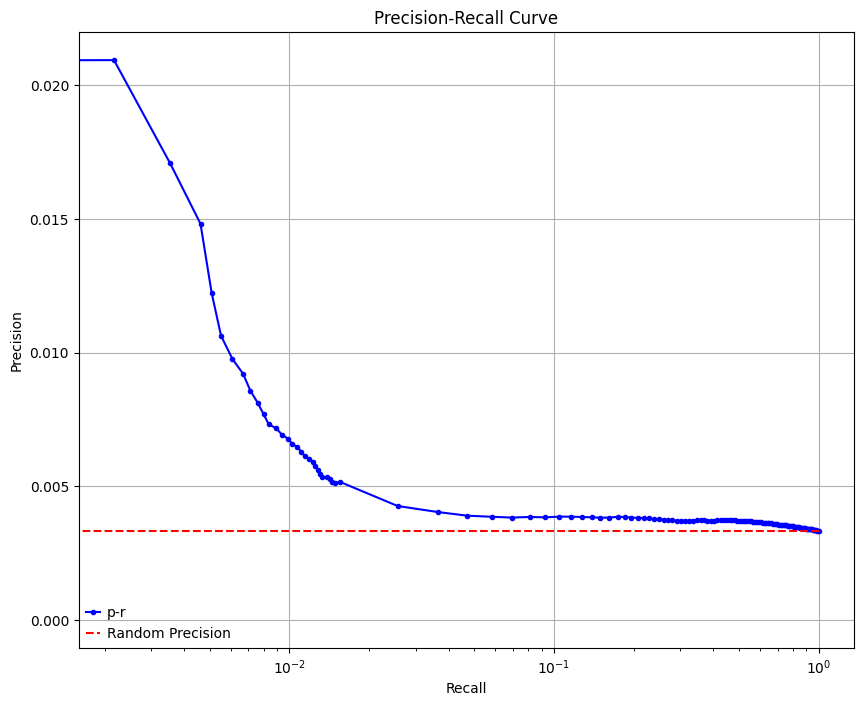

precision:  0.0005029854669496383 
recall:  1.0 
random precision: 0.0005031524053721241


 95%|█████████▍| 121/128 [00:01<00:00, 104.92it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 104.91it/s]


Average Precision (AP):  0.00075507091505666
Area Under Precision-Recall Curve (AUPRC):  0.0007429638483895612
EPR: 9.452886476520648


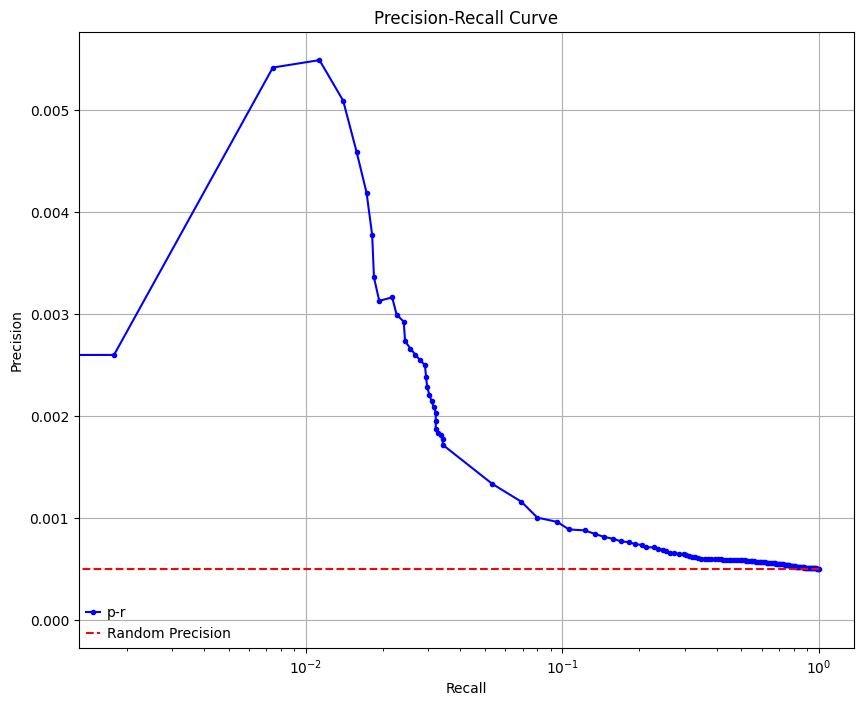

number of expressed genes in this cell type: 14685


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


predict epoch start


100%|██████████| 64/64 [00:03<00:00, 16.36it/s]


avg link count: 13623481, sparsity: 1.0
loading GT,  collectri
intersection of 1752 genes
intersection pct: 0.4756991582948683
only tf:  False
using only tf:  0.4756991582948683
total true edges:  5082.0
precision:  0.0016556420841934072 
recall:  1.0 
random precision: 0.0016565876250752994


 95%|█████████▌| 122/128 [00:00<00:00, 239.80it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 239.13it/s]


Average Precision (AP):  0.002245131342712549
Area Under Precision-Recall Curve (AUPRC):  0.002242334731636479
EPR: 0.47512832057213295


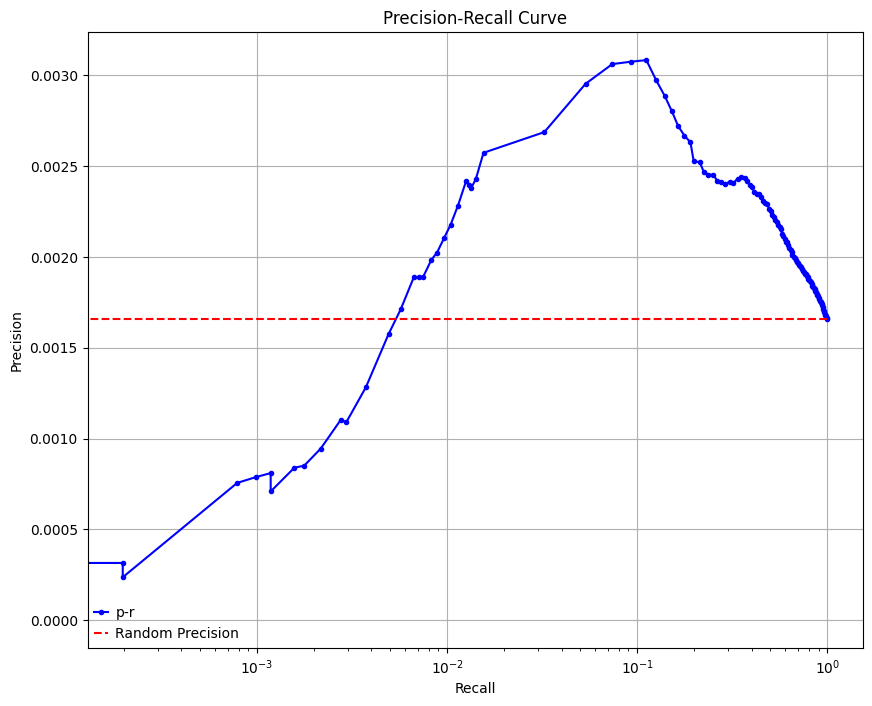

loading GT,  omnipath
intersection of 2674 genes
intersection pct: 0.7260385555253869
only tf:  False
using only tf:  0.7260385555253869
total true edges:  12263.0
precision:  0.0017150386922127202 
recall:  1.0 
random precision: 0.0017156803078850781


 98%|█████████▊| 125/128 [00:01<00:00, 80.75it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 80.49it/s]


Average Precision (AP):  0.002805581270491533
Area Under Precision-Recall Curve (AUPRC):  0.0028035382304503337
EPR: 1.283307313563974


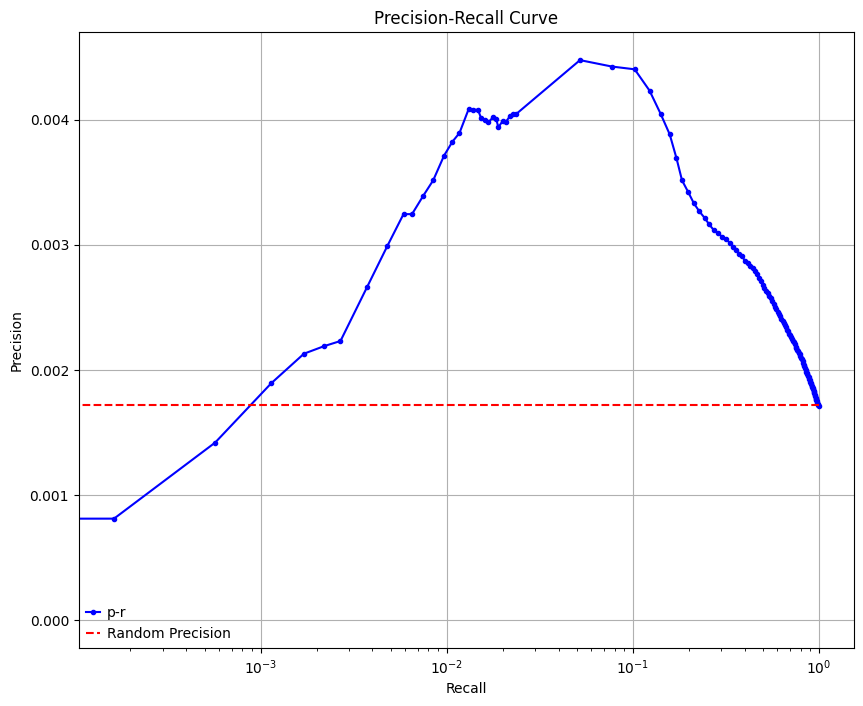

precision:  0.0022007547734210786 
recall:  1.0 
random precision: 0.0022020663078510076


 81%|████████▏ | 104/128 [00:00<00:00, 1039.82it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1034.93it/s]


Average Precision (AP):  0.0024599799741398865
Area Under Precision-Recall Curve (AUPRC):  0.0024536909920569697
No true positives found. Returning EPR as 0.
EPR: 0.0


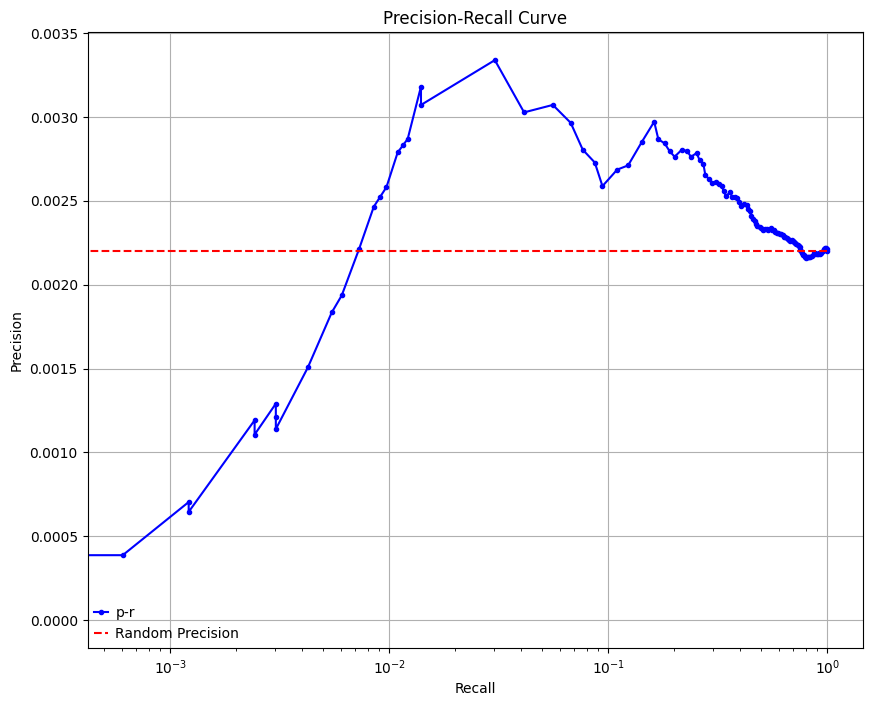

precision:  0.0022007547734210786 
recall:  1.0 
random precision: 0.0022020663078510076


 81%|████████▏ | 104/128 [00:00<00:00, 1039.11it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1033.40it/s]


Average Precision (AP):  0.0024599799741398865
Area Under Precision-Recall Curve (AUPRC):  0.0024536909920569697
No true positives found. Returning EPR as 0.
EPR: 0.0


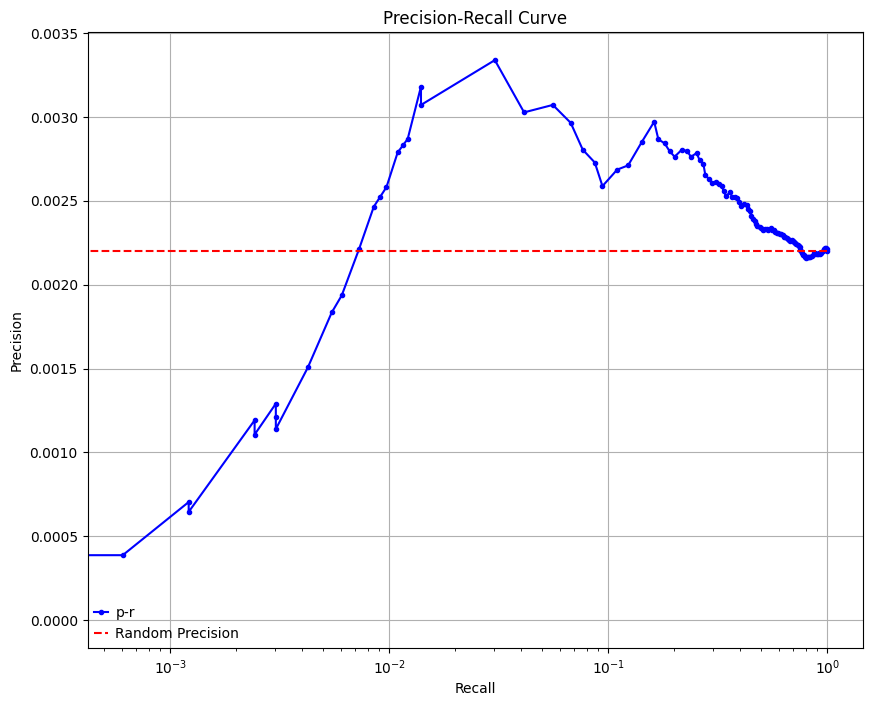

precision:  0.0033202743561688963 
recall:  1.0 
random precision: 0.0033214075556078615


 98%|█████████▊| 126/128 [00:02<00:00, 54.12it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 54.03it/s]


Average Precision (AP):  0.003856707322822372
Area Under Precision-Recall Curve (AUPRC):  0.0038363061191326858
EPR: 2.7097159008698064


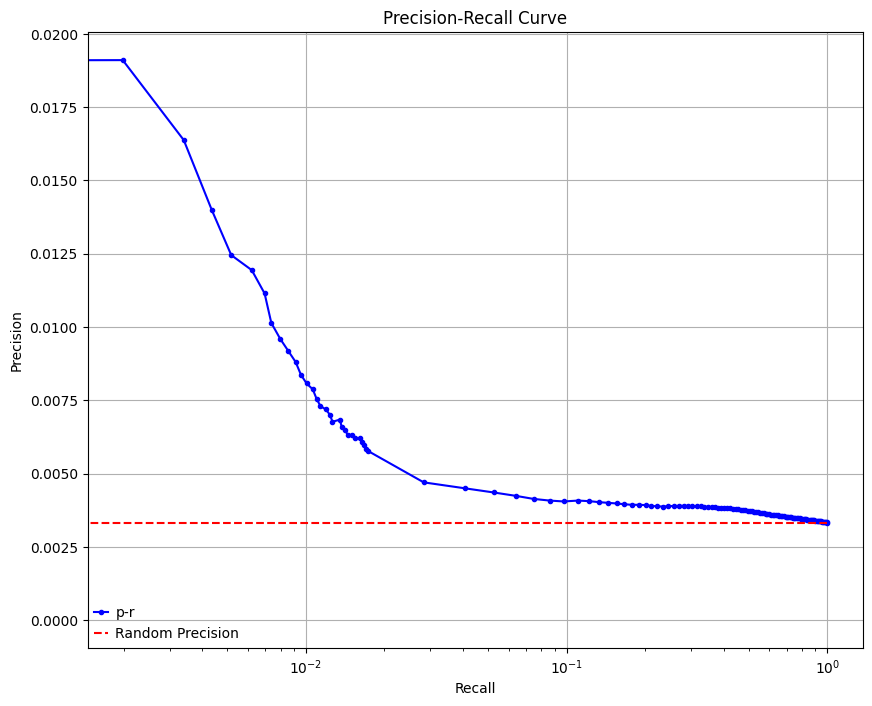

precision:  0.000577479560761717 
recall:  1.0 
random precision: 0.000577676652761977


 94%|█████████▍| 120/128 [00:01<00:00, 93.40it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 93.31it/s]


Average Precision (AP):  0.0008716646336338009
Area Under Precision-Recall Curve (AUPRC):  0.0008631113501905528
EPR: 8.99627242648995


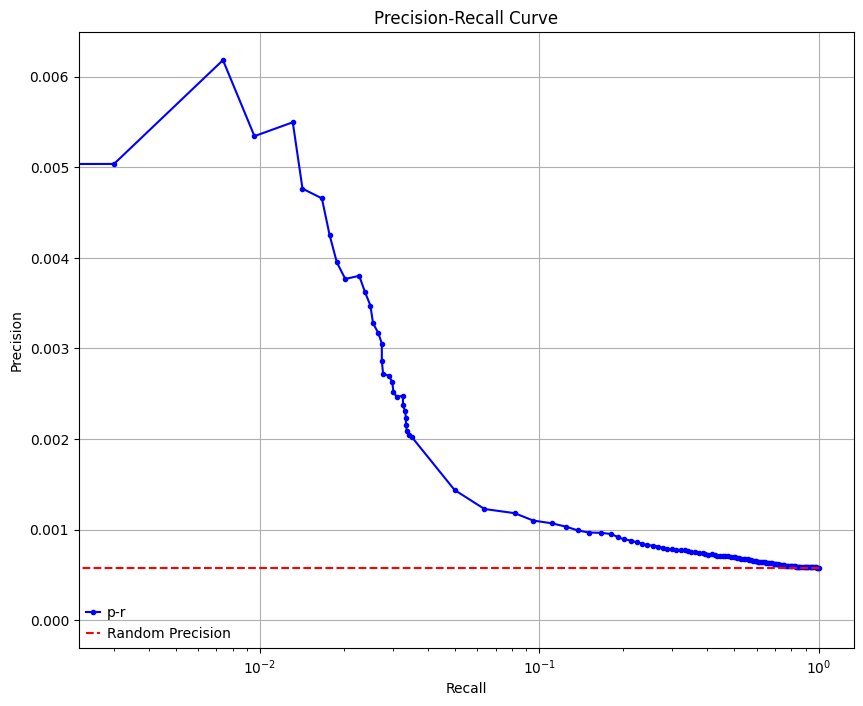

number of expressed genes in this cell type: 14304


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


predict epoch start


100%|██████████| 64/64 [00:04<00:00, 15.66it/s]


avg link count: 14227984, sparsity: 1.0
loading GT,  collectri
intersection of 1752 genes
intersection pct: 0.46546227417640806
only tf:  False
using only tf:  0.46546227417640806
total true edges:  3686.0
precision:  0.001200845478618044 
recall:  1.0 
random precision: 0.0012015312841455242


 86%|████████▌ | 110/128 [00:00<00:00, 217.07it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 216.83it/s]


Average Precision (AP):  0.0017966800025785259
Area Under Precision-Recall Curve (AUPRC):  0.0017865491439520076
EPR: 0.22579253846953276


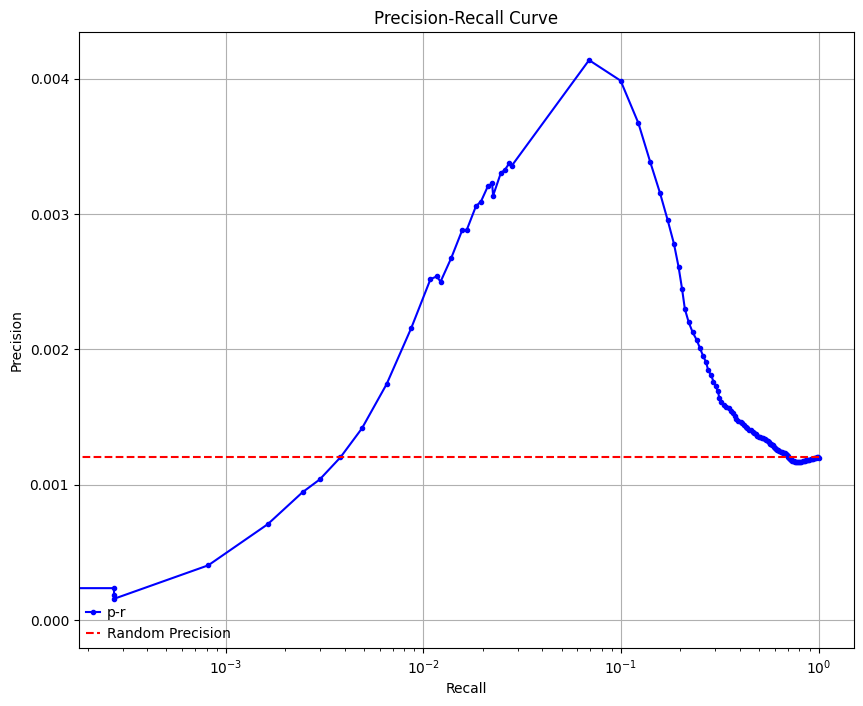

loading GT,  omnipath
intersection of 2741 genes
intersection pct: 0.7282146652497343
only tf:  False
using only tf:  0.7282146652497343
total true edges:  10814.0
precision:  0.0014393562374743463 
recall:  1.0 
random precision: 0.001439881549969775


 94%|█████████▍| 120/128 [00:01<00:00, 75.40it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 75.19it/s]


Average Precision (AP):  0.002399625222260653
Area Under Precision-Recall Curve (AUPRC):  0.0023910141635906006
EPR: 1.9266734937199443


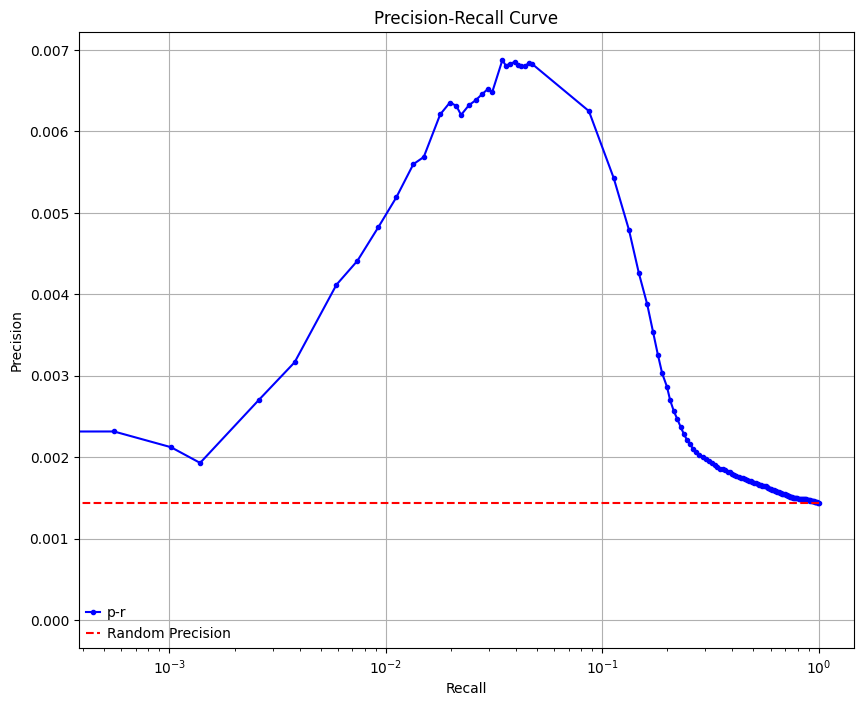

precision:  0.0024410482902542468 
recall:  1.0 
random precision: 0.0024424021717241603


 68%|██████▊   | 87/128 [00:00<00:00, 864.75it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 862.85it/s]


Average Precision (AP):  0.0027453811374845293
Area Under Precision-Recall Curve (AUPRC):  0.0027382348650563898
EPR: 0.5657756520407083


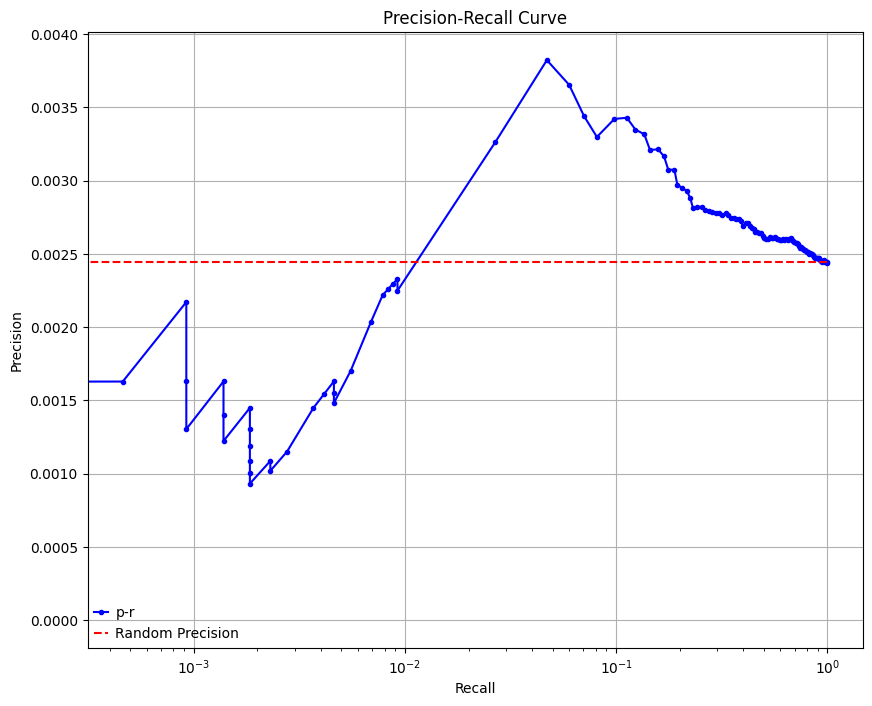

precision:  0.0024410482902542468 
recall:  1.0 
random precision: 0.0024424021717241603


 68%|██████▊   | 87/128 [00:00<00:00, 868.36it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 865.93it/s]


Average Precision (AP):  0.0027453811374845293
Area Under Precision-Recall Curve (AUPRC):  0.0027382348650563898
EPR: 0.5657756520407083


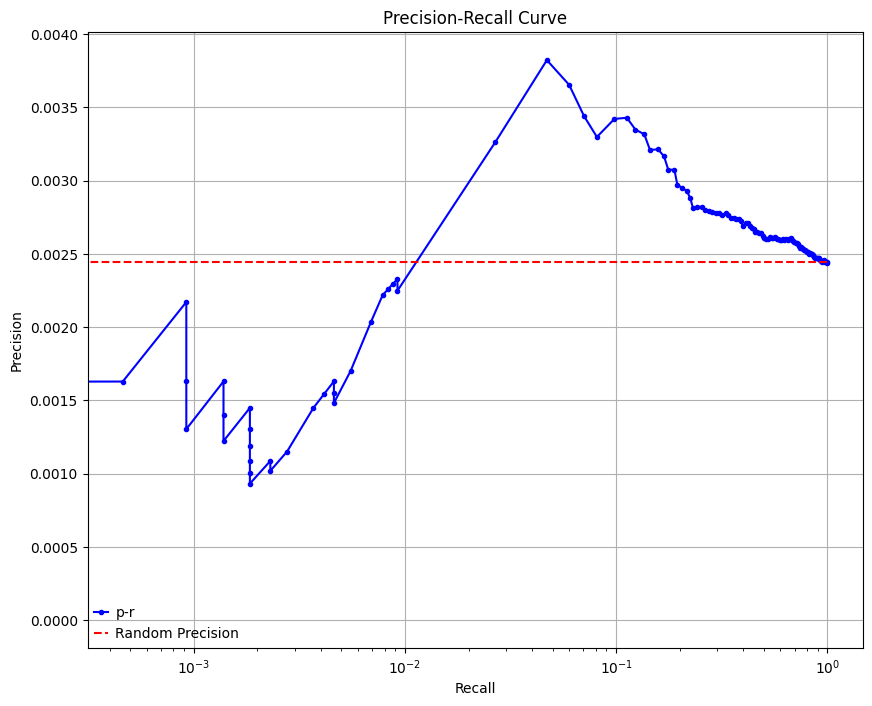

precision:  0.003367953925015091 
recall:  1.0 
random precision: 0.003369066930277819


 98%|█████████▊| 126/128 [00:02<00:00, 60.72it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 60.66it/s]


Average Precision (AP):  0.003781589580348783
Area Under Precision-Recall Curve (AUPRC):  0.003765486763053893
EPR: 2.2724588494065783


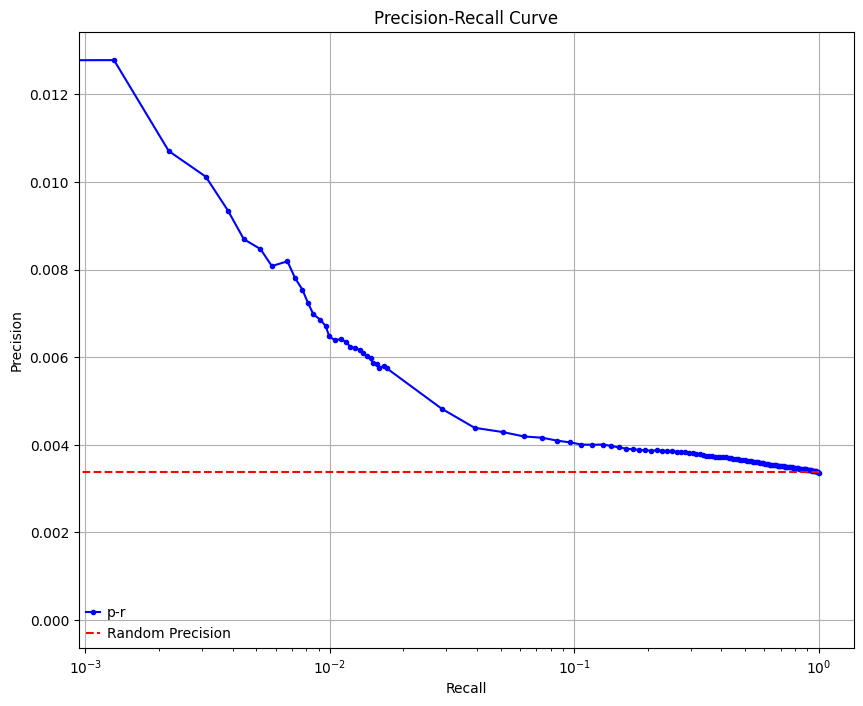

precision:  0.0005464326552273234 
recall:  1.0 
random precision: 0.0005466132344260104


 95%|█████████▍| 121/128 [00:01<00:00, 101.66it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 101.46it/s]


Average Precision (AP):  0.0007198767218621724
Area Under Precision-Recall Curve (AUPRC):  0.0007089164672483043
EPR: 8.371628750346439


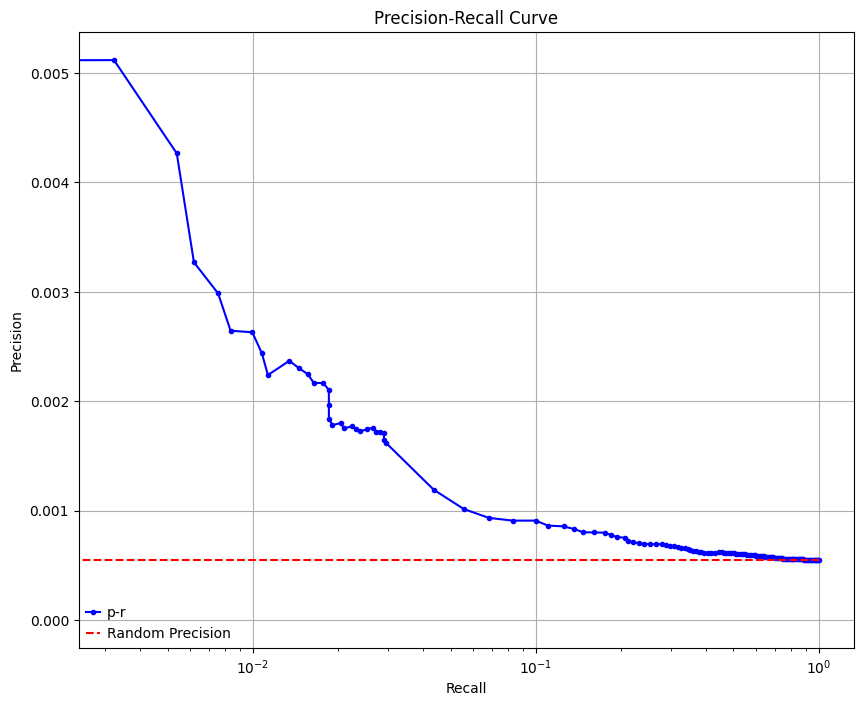

number of expressed genes in this cell type: 12280


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


predict epoch start


100%|██████████| 64/64 [00:03<00:00, 16.04it/s]


avg link count: 13461561, sparsity: 1.0
loading GT,  collectri
intersection of 1711 genes
intersection pct: 0.46735864517891285
only tf:  False
using only tf:  0.46735864517891285
total true edges:  4932.0
precision:  0.0016847018347605363 
recall:  1.0 
random precision: 0.0016856870405118584


 81%|████████▏ | 104/128 [00:00<00:00, 256.53it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 256.19it/s]


Average Precision (AP):  0.002051908737089973
Area Under Precision-Recall Curve (AUPRC):  0.0020307934682426572
EPR: 0.8419727268960046


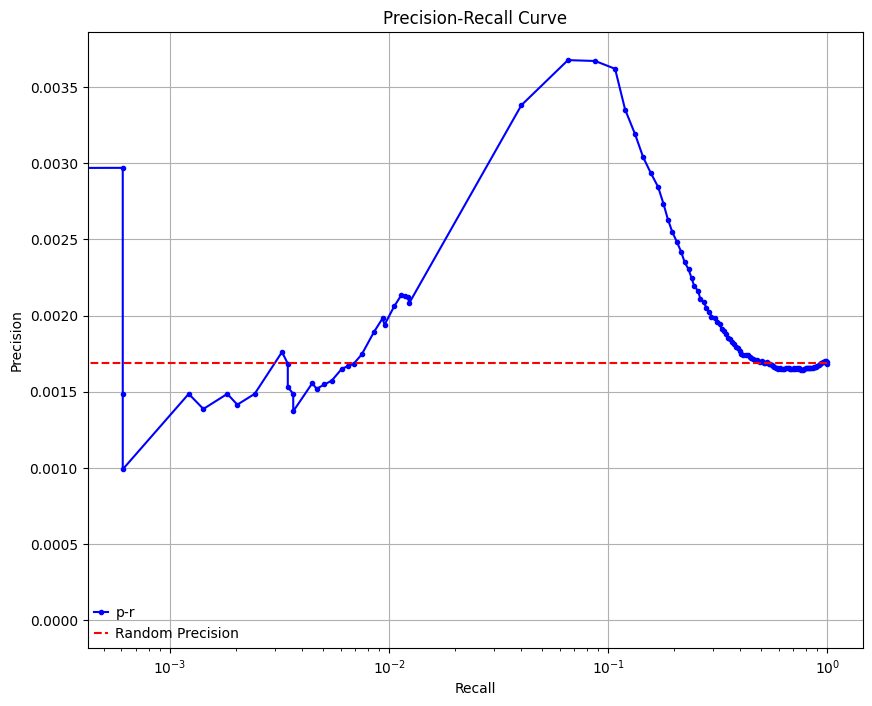

loading GT,  omnipath
intersection of 2677 genes
intersection pct: 0.7312209778748976
only tf:  False
using only tf:  0.7312209778748976
total true edges:  12083.0
precision:  0.0016860794417895132 
recall:  1.0 
random precision: 0.00168670951631933


 94%|█████████▍| 120/128 [00:01<00:00, 92.60it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 92.17it/s]


Average Precision (AP):  0.002813753233971633
Area Under Precision-Recall Curve (AUPRC):  0.002790592528548713
EPR: 3.5327867734664746


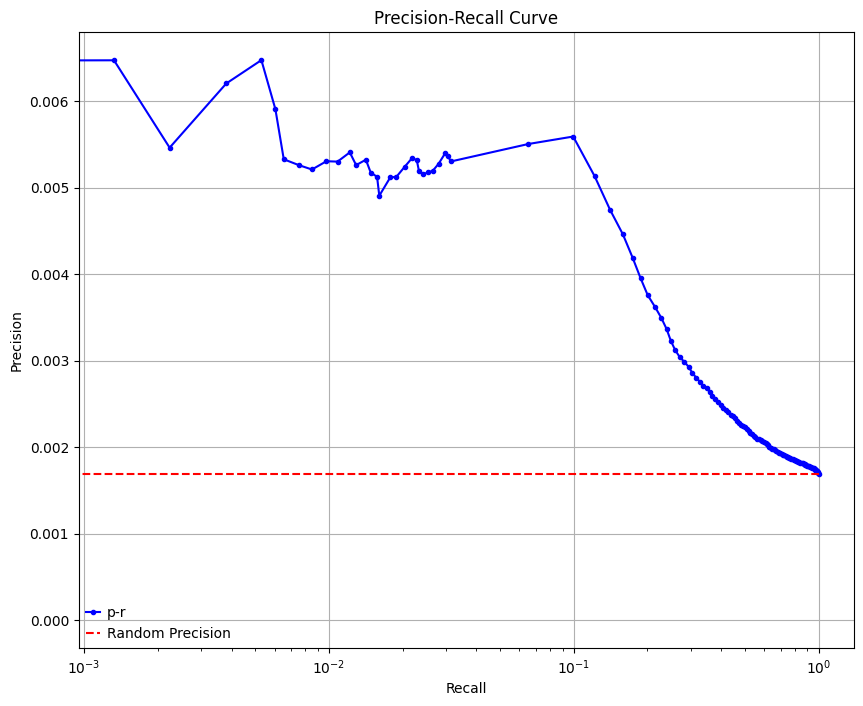

precision:  0.00243065695919019 
recall:  1.0 
random precision: 0.002432002837905135


 70%|██████▉   | 89/128 [00:00<00:00, 880.66it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 877.14it/s]


Average Precision (AP):  0.0026998406705982005
Area Under Precision-Recall Curve (AUPRC):  0.0026958545667712603
EPR: 1.1533905489909888


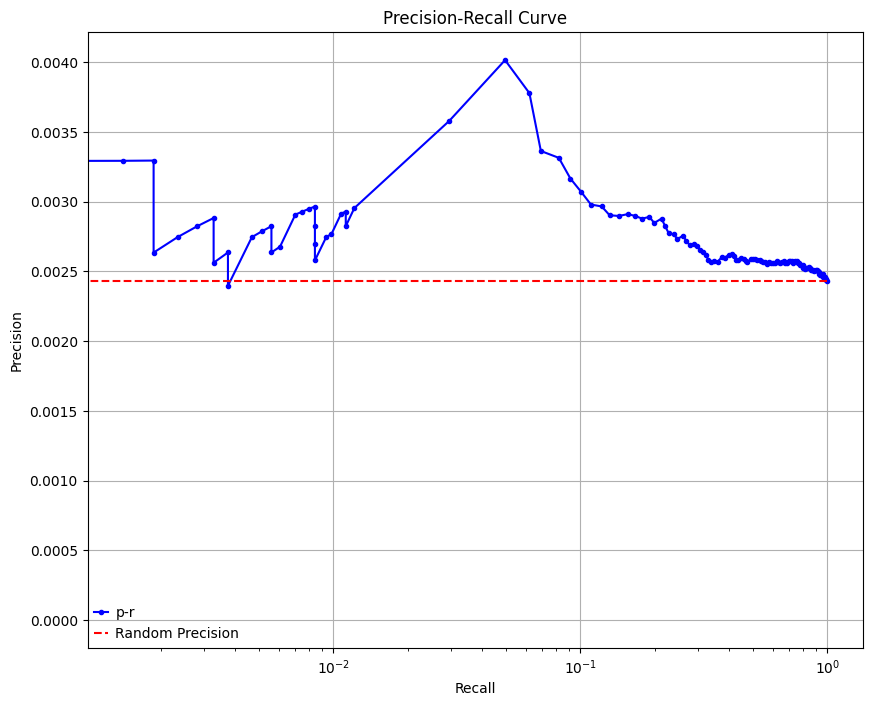

precision:  0.00243065695919019 
recall:  1.0 
random precision: 0.002432002837905135


 69%|██████▉   | 88/128 [00:00<00:00, 877.58it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 874.15it/s]


Average Precision (AP):  0.0026998406705982005
Area Under Precision-Recall Curve (AUPRC):  0.0026958545667712603
EPR: 1.1533905489909888


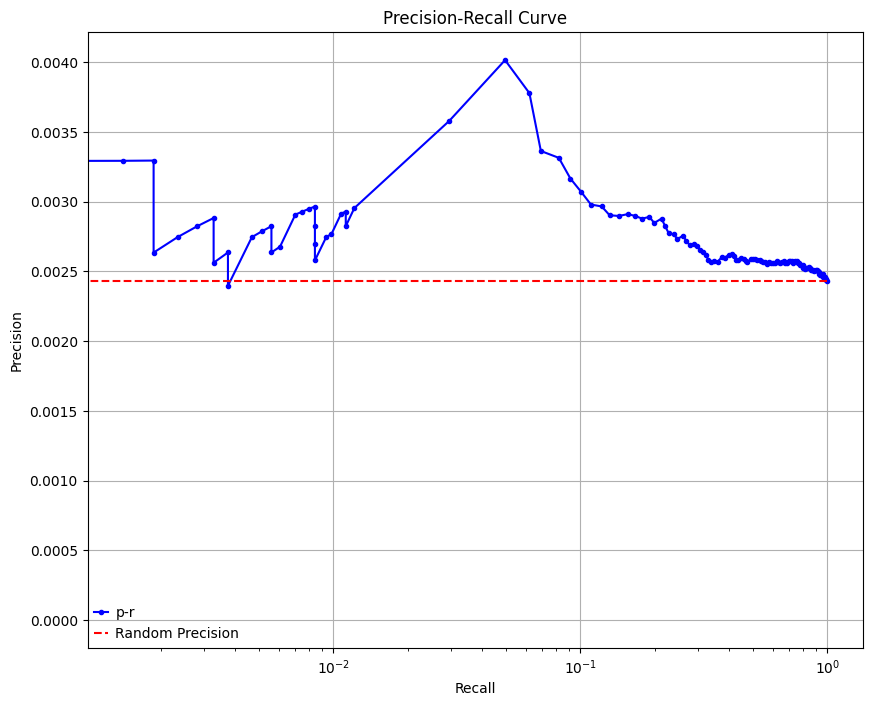

precision:  0.0037083348454805495 
recall:  1.0 
random precision: 0.0037095591224186415


 98%|█████████▊| 125/128 [00:02<00:00, 60.30it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 60.34it/s]


Average Precision (AP):  0.004236307950886452
Area Under Precision-Recall Curve (AUPRC):  0.004199170086279234
EPR: 2.246448448003163


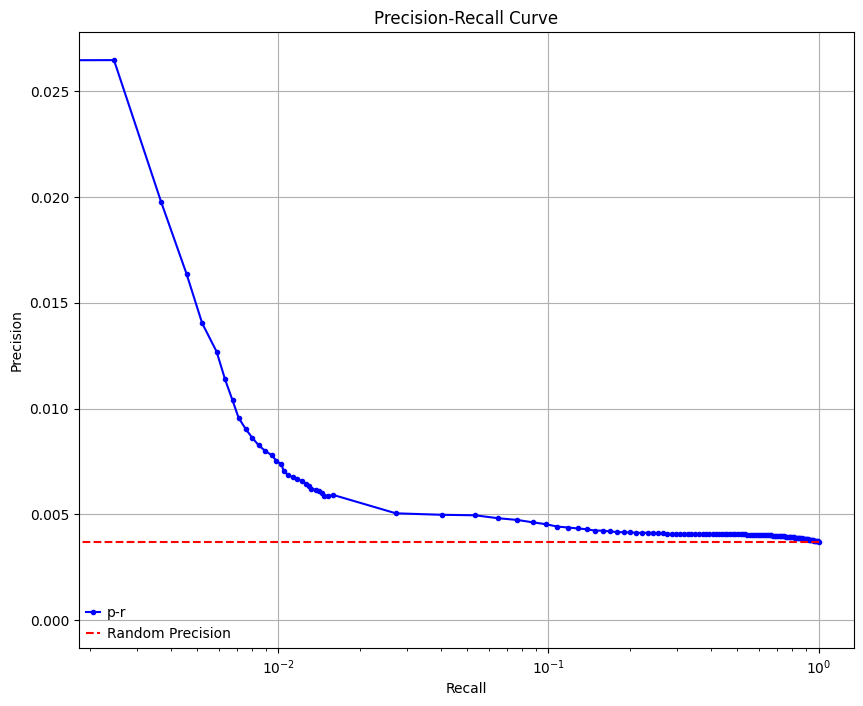

precision:  0.000681921525485882 
recall:  1.0 
random precision: 0.0006821466563955834


 95%|█████████▍| 121/128 [00:01<00:00, 101.16it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 101.06it/s]


Average Precision (AP):  0.0009629662739041072
Area Under Precision-Recall Curve (AUPRC):  0.0009095565037949163
EPR: 11.036484137634218


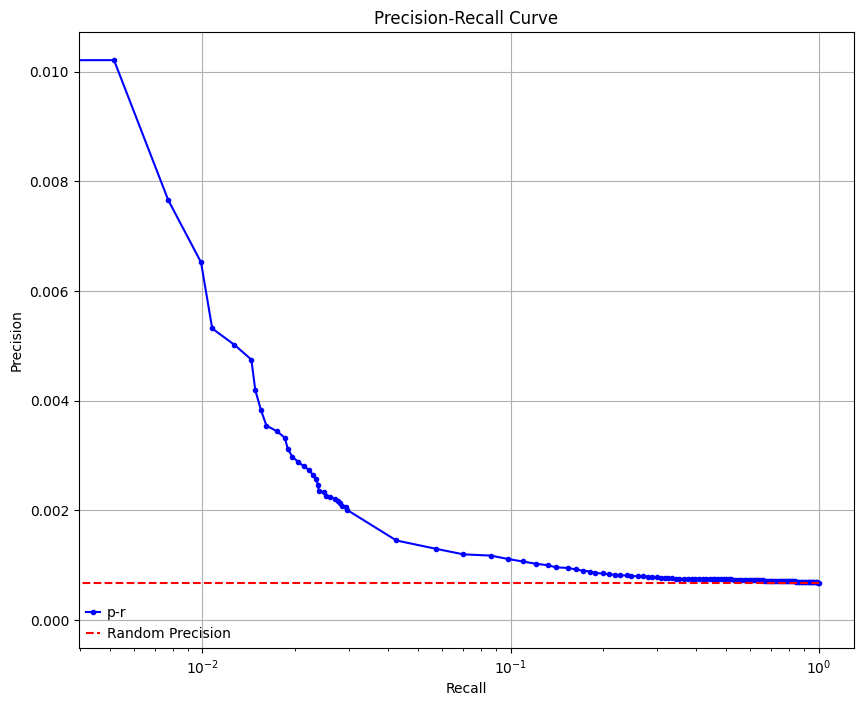

number of expressed genes in this cell type: 13612


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


predict epoch start


100%|██████████| 64/64 [00:03<00:00, 16.13it/s]


avg link count: 13380964, sparsity: 1.0
loading GT,  collectri
intersection of 1732 genes
intersection pct: 0.4745205479452055
only tf:  False
using only tf:  0.4745205479452055
total true edges:  4576.0
precision:  0.001525422824805722 
recall:  1.0 
random precision: 0.0015263040627172214


 98%|█████████▊| 125/128 [00:00<00:00, 244.67it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 243.90it/s]


Average Precision (AP):  0.0021100277651139635
Area Under Precision-Recall Curve (AUPRC):  0.0021029682629947477
No true positives found. Returning EPR as 0.
EPR: 0.0


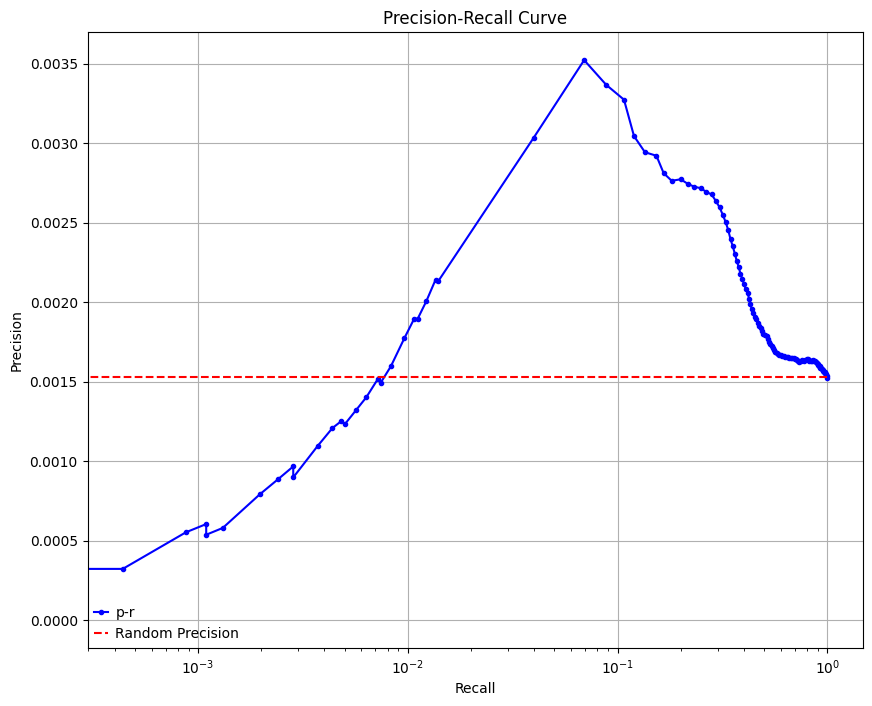

loading GT,  omnipath
intersection of 2656 genes
intersection pct: 0.7276712328767123
only tf:  False
using only tf:  0.7276712328767123
total true edges:  11669.0
precision:  0.0016541599379445494 
recall:  1.0 
random precision: 0.0016547829737027205


 94%|█████████▍| 120/128 [00:01<00:00, 83.57it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 88.55it/s]


Average Precision (AP):  0.002827658142593077
Area Under Precision-Recall Curve (AUPRC):  0.002823607533856724
EPR: 2.3822270302253594


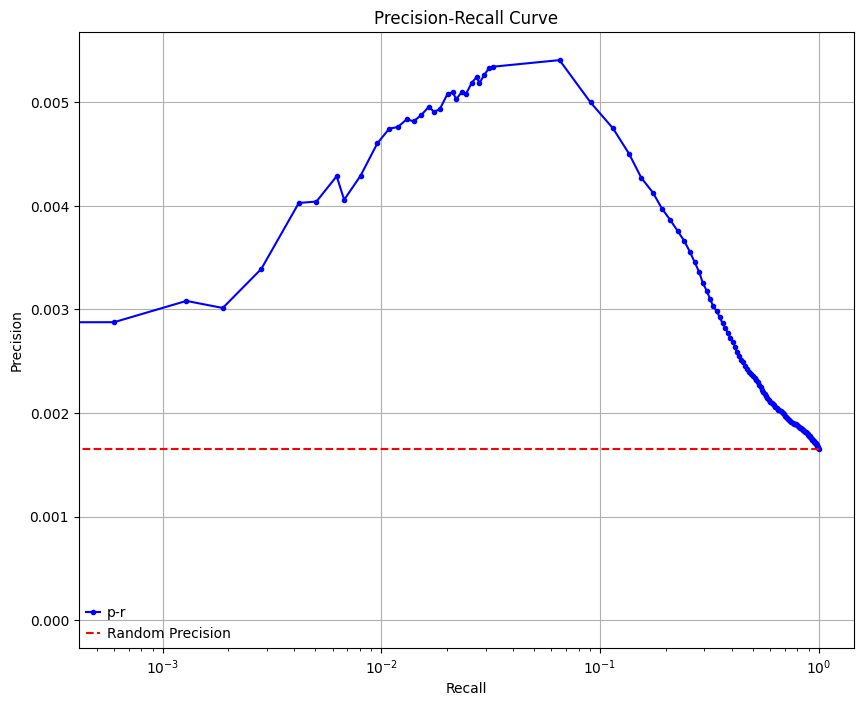

precision:  0.002460724720713958 
recall:  1.0 
random precision: 0.00246215371300241


 76%|███████▌  | 97/128 [00:00<00:00, 961.17it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 957.14it/s]


Average Precision (AP):  0.0029117001517864807
Area Under Precision-Recall Curve (AUPRC):  0.0028222143569289577
EPR: 1.4358784817875727


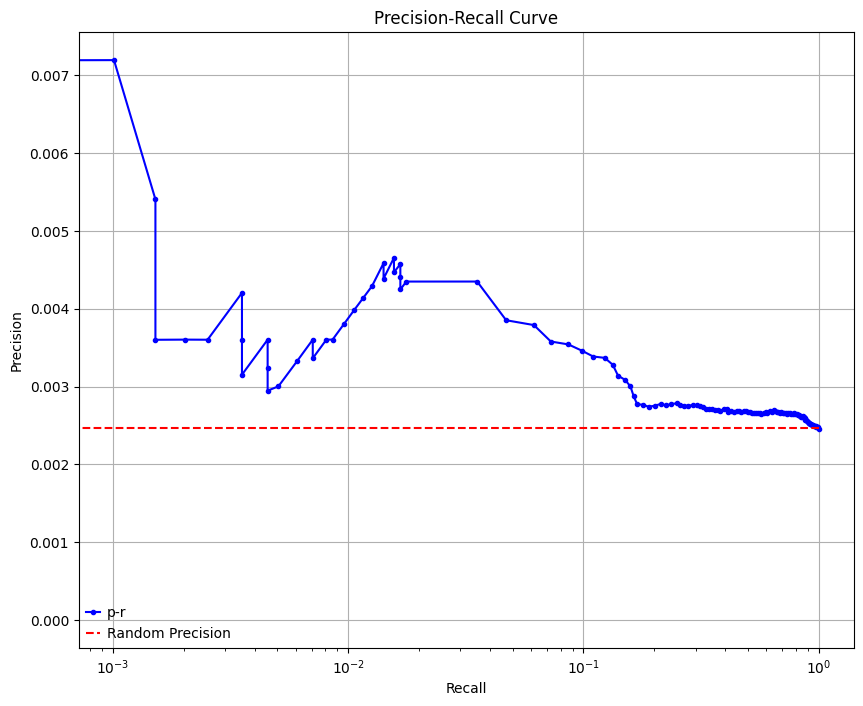

precision:  0.002460724720713958 
recall:  1.0 
random precision: 0.00246215371300241


 76%|███████▌  | 97/128 [00:00<00:00, 964.91it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 960.05it/s]


Average Precision (AP):  0.0029117001517864807
Area Under Precision-Recall Curve (AUPRC):  0.0028222143569289577
EPR: 1.4358784817875727


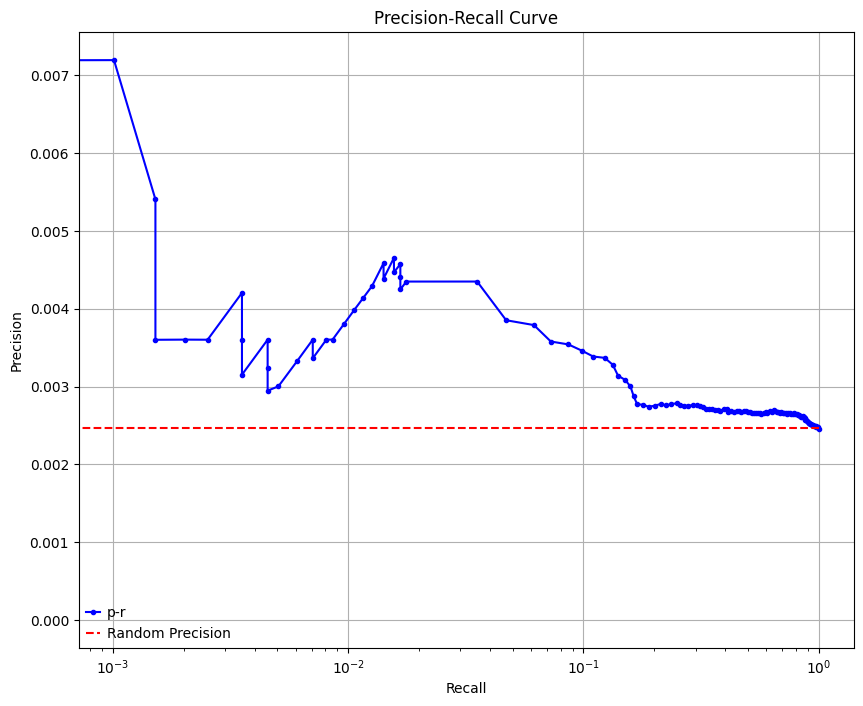

precision:  0.003513577168753223 
recall:  1.0 
random precision: 0.003514752278174211


 98%|█████████▊| 126/128 [00:02<00:00, 52.65it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 52.16it/s]


Average Precision (AP):  0.0038708313788098636
Area Under Precision-Recall Curve (AUPRC):  0.0038577522992340094
EPR: 1.8816047057463505


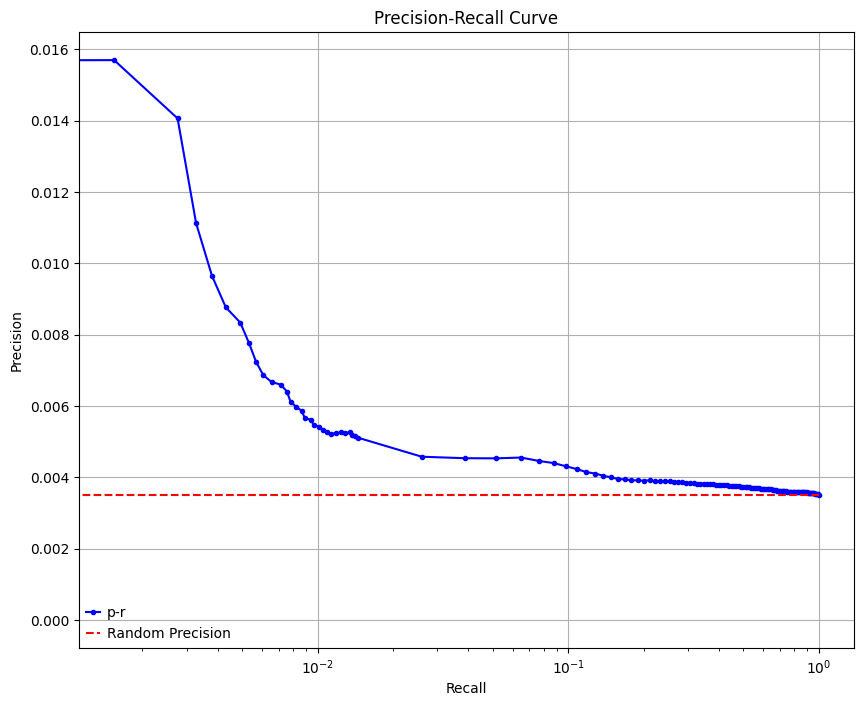

precision:  0.0006291519485994214 
recall:  1.0 
random precision: 0.0006293623673113276


 94%|█████████▍| 120/128 [00:01<00:00, 92.27it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 92.13it/s]


Average Precision (AP):  0.0007294334219004334
Area Under Precision-Recall Curve (AUPRC):  0.0007265329764612701
EPR: 3.441681763088272


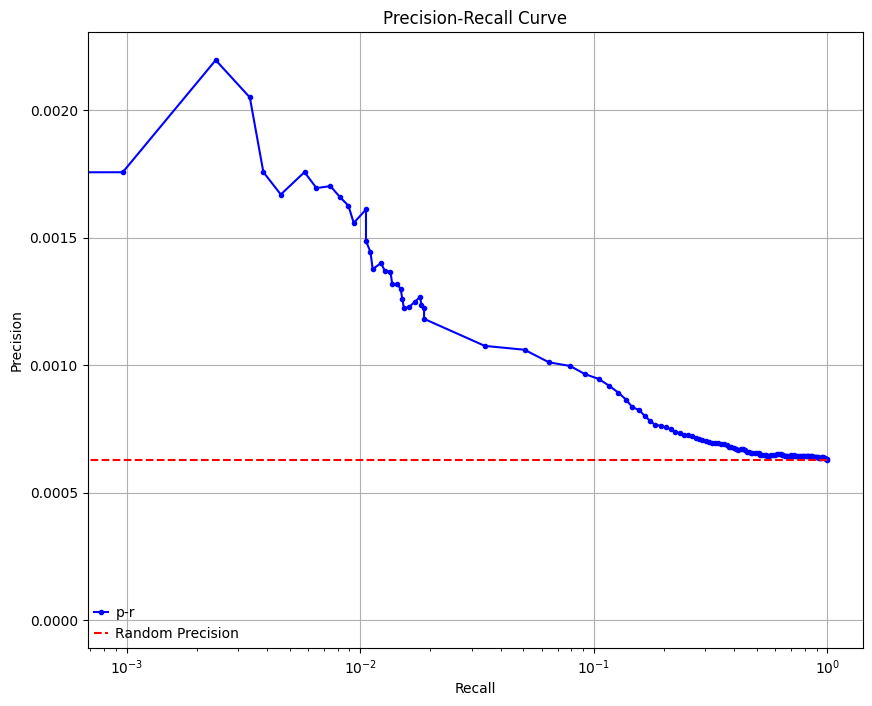

number of expressed genes in this cell type: 13737


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


predict epoch start


100%|██████████| 64/64 [00:04<00:00, 15.80it/s]


avg link count: 13380964, sparsity: 1.0
loading GT,  collectri
intersection of 1735 genes
intersection pct: 0.47534246575342465
only tf:  False
using only tf:  0.47534246575342465
total true edges:  4580.0
precision:  0.0015214809524205 
recall:  1.0 
random precision: 0.001522358392416129


 98%|█████████▊| 125/128 [00:00<00:00, 247.83it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 247.34it/s]


Average Precision (AP):  0.0022415336324816742
Area Under Precision-Recall Curve (AUPRC):  0.002233304005423953
EPR: 2.438184340496939


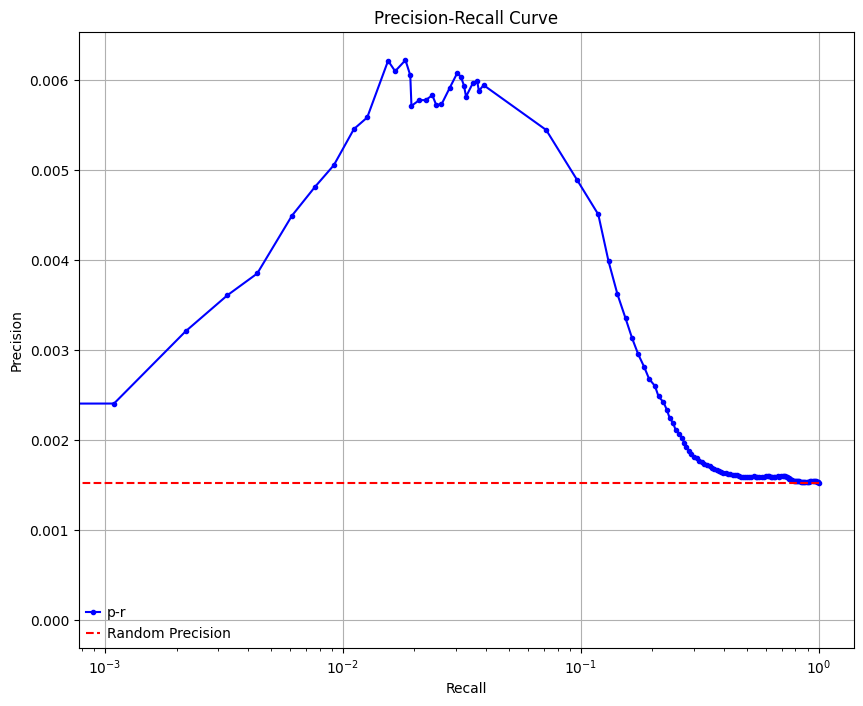

loading GT,  omnipath
intersection of 2625 genes
intersection pct: 0.7191780821917808
only tf:  False
using only tf:  0.7191780821917808
total true edges:  13455.0
precision:  0.0019526530612244898 
recall:  1.0 
random precision: 0.001953397212543554


 98%|█████████▊| 126/128 [00:01<00:00, 81.64it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 81.46it/s]


Average Precision (AP):  0.003036832567610206
Area Under Precision-Recall Curve (AUPRC):  0.003033932343429758
EPR: 4.261316158945939


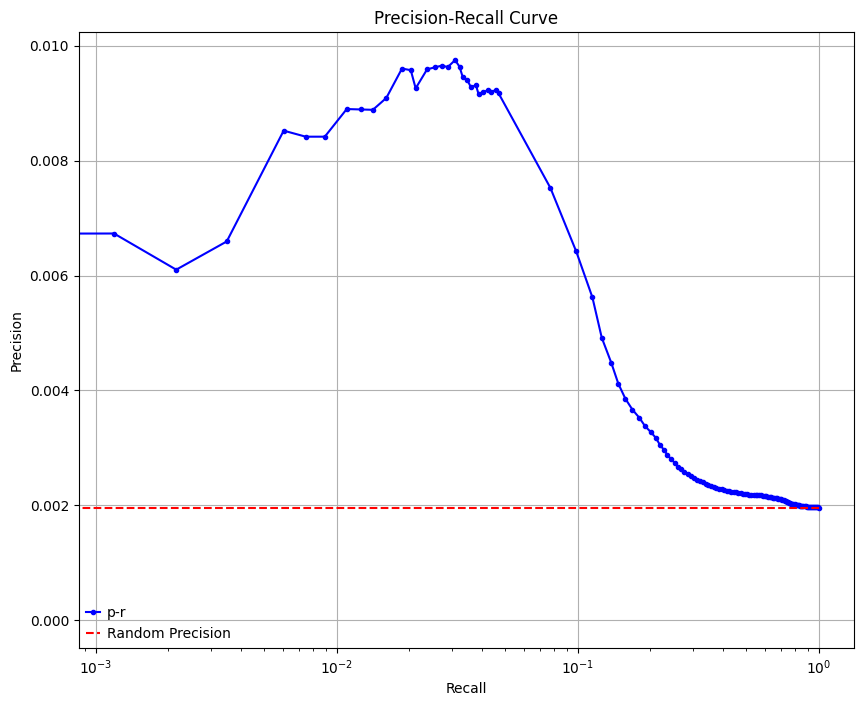

precision:  0.002630950135194617 
recall:  1.0 
random precision: 0.0026325227294176864


 76%|███████▌  | 97/128 [00:00<00:00, 960.25it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 956.17it/s]


Average Precision (AP):  0.003261316866901108
Area Under Precision-Recall Curve (AUPRC):  0.0032564781314774697
EPR: 3.63158476797707


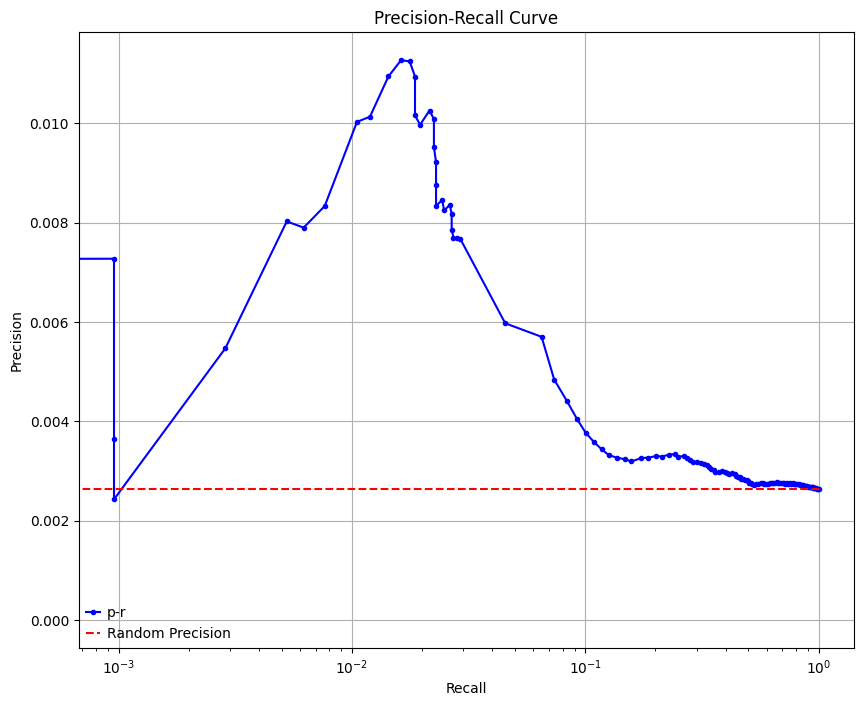

precision:  0.002630950135194617 
recall:  1.0 
random precision: 0.0026325227294176864


 76%|███████▌  | 97/128 [00:00<00:00, 961.35it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 957.07it/s]


Average Precision (AP):  0.003261316866901108
Area Under Precision-Recall Curve (AUPRC):  0.0032564781314774697
EPR: 3.63158476797707


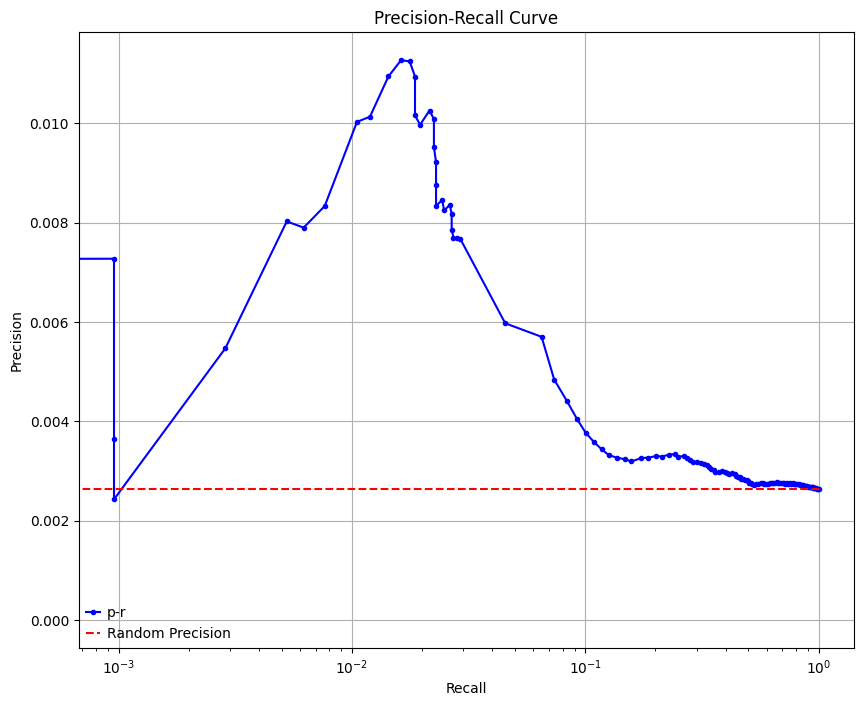

precision:  0.0032318697180226475 
recall:  1.0 
random precision: 0.0032329761438076605


 98%|█████████▊| 126/128 [00:02<00:00, 55.30it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 55.10it/s]


Average Precision (AP):  0.003769170547690047
Area Under Precision-Recall Curve (AUPRC):  0.003718839125484954
EPR: 2.4551306545512124


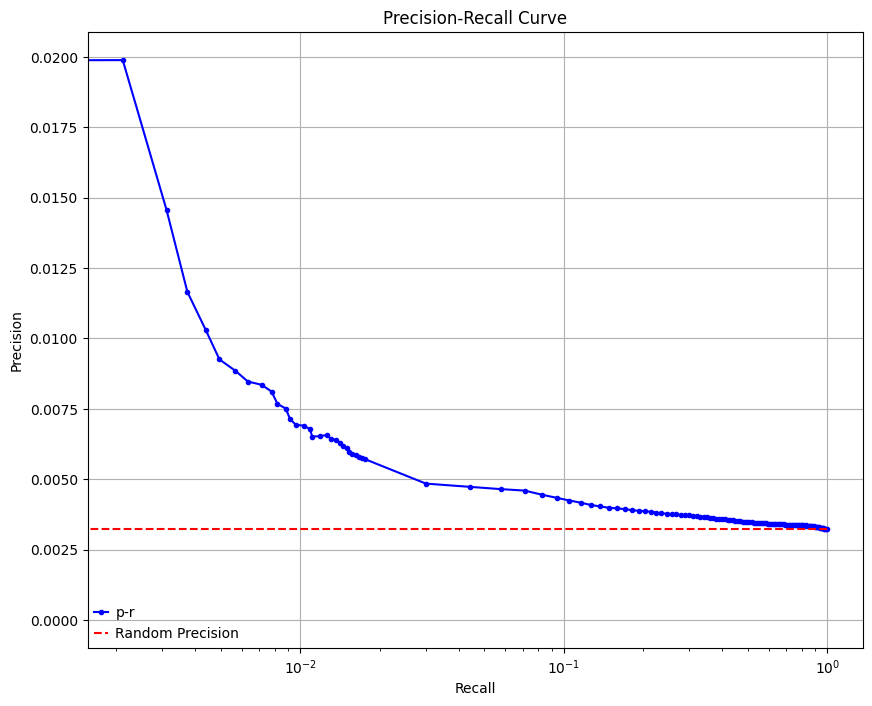

precision:  0.000547190603250755 
recall:  1.0 
random precision: 0.0005473779331388929


 94%|█████████▍| 120/128 [00:01<00:00, 94.62it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 94.45it/s]


Average Precision (AP):  0.0008774239534851701
Area Under Precision-Recall Curve (AUPRC):  0.0007419965905188435
EPR: 8.976055665074009


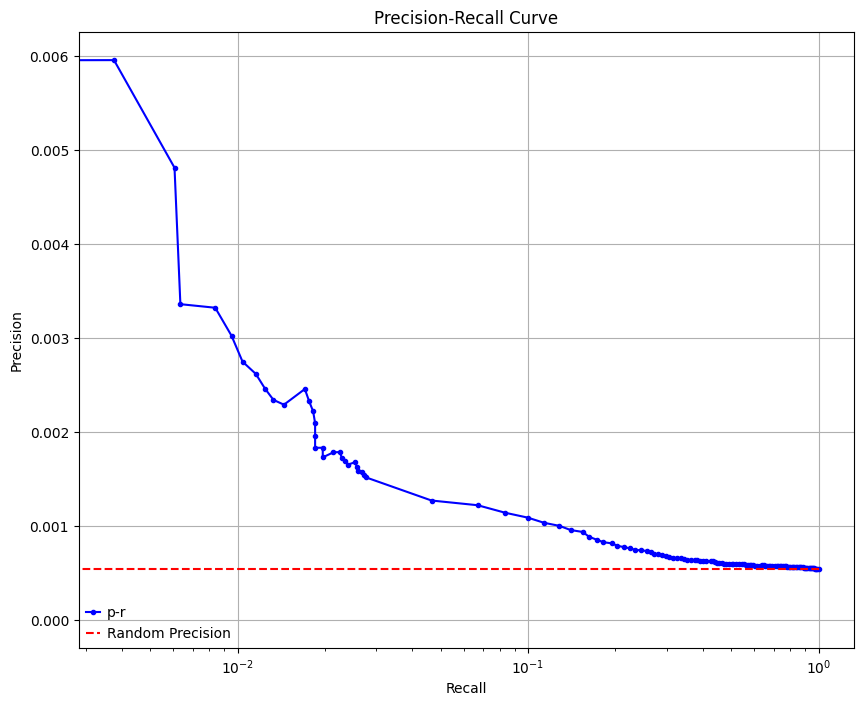

number of expressed genes in this cell type: 13497


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


predict epoch start


100%|██████████| 64/64 [00:04<00:00, 15.75it/s]


avg link count: 13169641, sparsity: 1.0
loading GT,  collectri
intersection of 1740 genes
intersection pct: 0.48053024026512015
only tf:  False
using only tf:  0.48053024026512015
total true edges:  5642.0
precision:  0.001863522261857577 
recall:  1.0 
random precision: 0.0018645938675285704


 86%|████████▌ | 110/128 [00:00<00:00, 217.59it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 217.16it/s]


Average Precision (AP):  0.0022541675147945395
Area Under Precision-Recall Curve (AUPRC):  0.002248474924593263
EPR: 0.09505668543301046


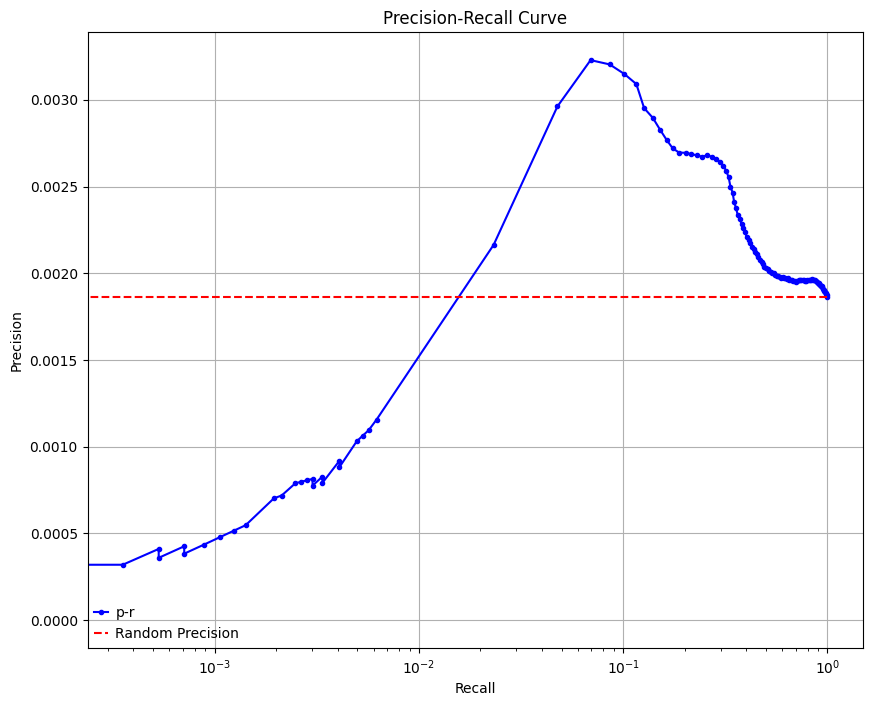

loading GT,  omnipath
intersection of 2639 genes
intersection pct: 0.7288041977354321
only tf:  False
using only tf:  0.7288041977354321
total true edges:  12497.0
precision:  0.0017944319338525608 
recall:  1.0 
random precision: 0.0017951121582399196


 99%|█████████▉| 127/128 [00:01<00:00, 79.82it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 79.70it/s]


Average Precision (AP):  0.0026569161960756267
Area Under Precision-Recall Curve (AUPRC):  0.0026522662034466245
EPR: 1.6047417163907447


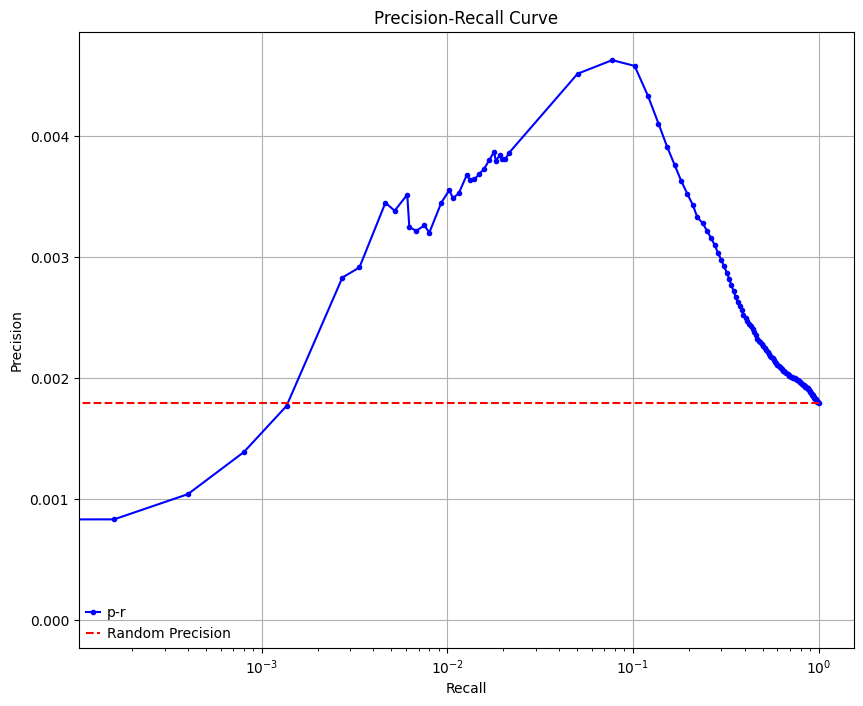

precision:  0.0025644517066085695 
recall:  1.0 
random precision: 0.0025660240252514933


 80%|███████▉  | 102/128 [00:00<00:00, 1019.05it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1016.31it/s]


Average Precision (AP):  0.0030789636505841236
Area Under Precision-Recall Curve (AUPRC):  0.003071815327963443
EPR: 0.4057344764203747


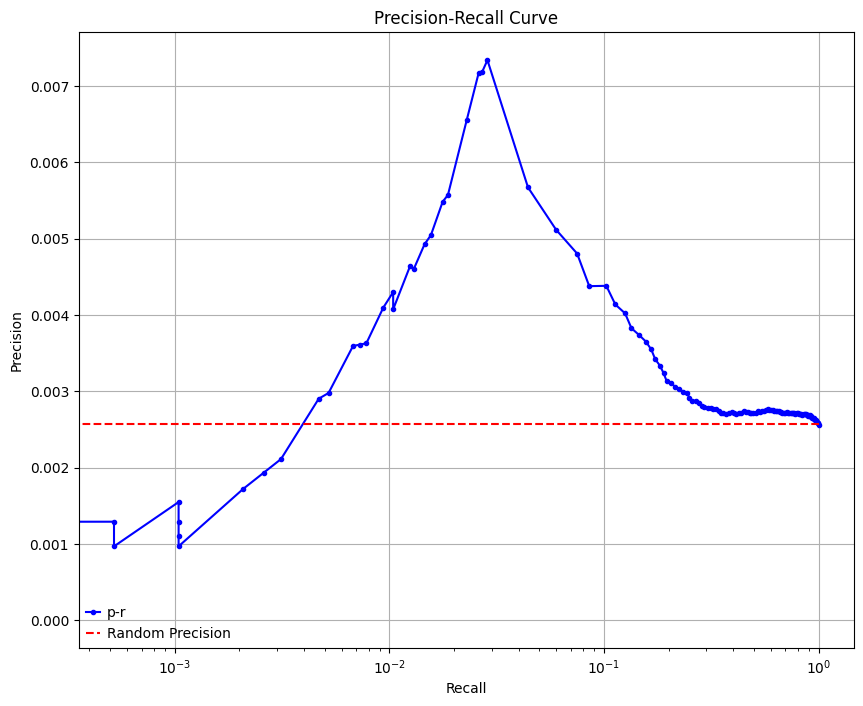

precision:  0.0025644517066085695 
recall:  1.0 
random precision: 0.0025660240252514933


 80%|████████  | 103/128 [00:00<00:00, 1023.13it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1017.94it/s]


Average Precision (AP):  0.0030789636505841236
Area Under Precision-Recall Curve (AUPRC):  0.003071815327963443
EPR: 0.4057344764203747


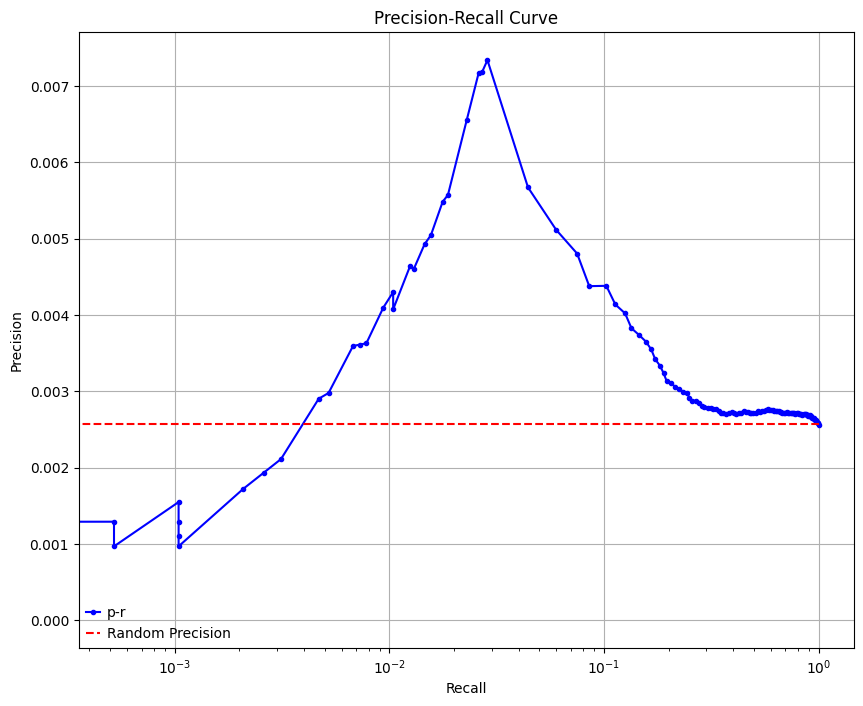

precision:  0.003302037721925473 
recall:  1.0 
random precision: 0.003303175178943015


 98%|█████████▊| 126/128 [00:02<00:00, 53.99it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 54.70it/s]


Average Precision (AP):  0.0036260942204121883
Area Under Precision-Recall Curve (AUPRC):  0.003611360297909579
EPR: 1.9270816100167727


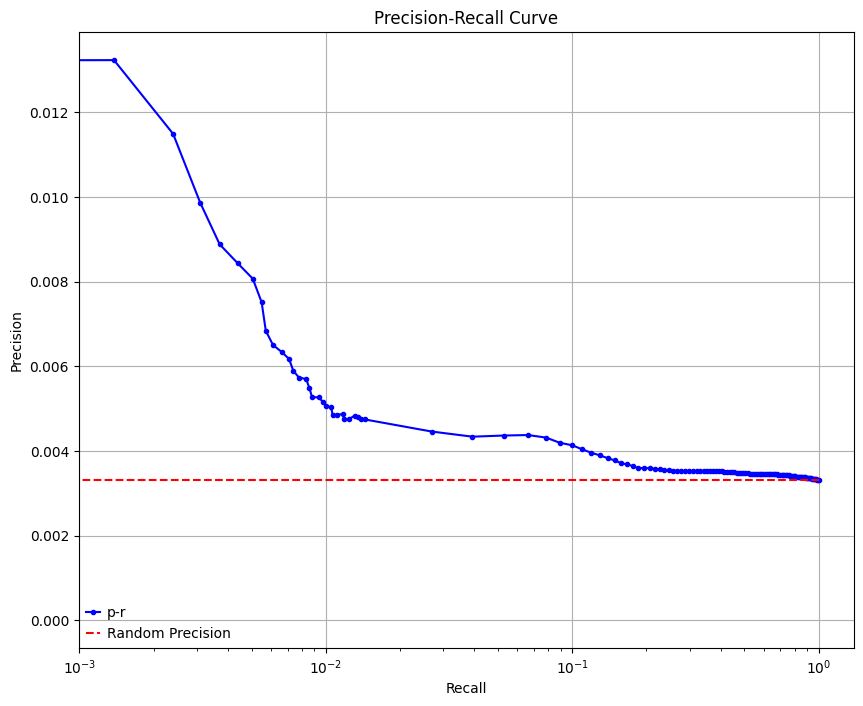

precision:  0.0005689515475611732 
recall:  1.0 
random precision: 0.0005691475350043566


 94%|█████████▍| 120/128 [00:01<00:00, 97.29it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 97.21it/s]


Average Precision (AP):  0.0006958272723041252
Area Under Precision-Recall Curve (AUPRC):  0.0006876530203248743
EPR: 5.504742348193061


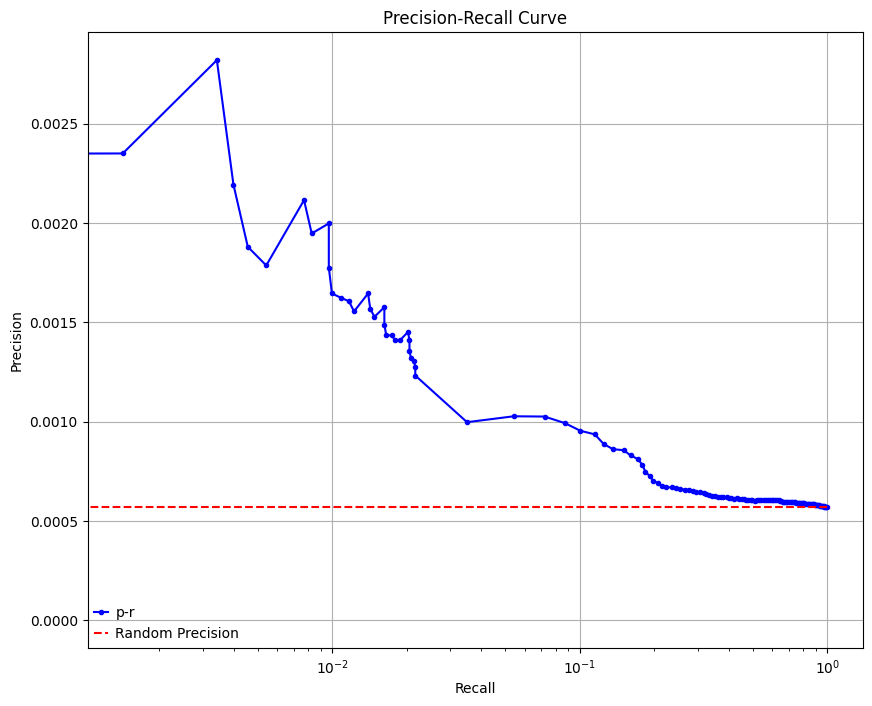

number of expressed genes in this cell type: 12640


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


predict epoch start


100%|██████████| 64/64 [00:04<00:00, 15.31it/s]


avg link count: 13184161, sparsity: 1.0
loading GT,  collectri
intersection of 1669 genes
intersection pct: 0.46066795473364613
only tf:  False
using only tf:  0.46066795473364613
total true edges:  3249.0
precision:  0.0011663718726676602 
recall:  1.0 
random precision: 0.0011670711363802905


 84%|████████▍ | 108/128 [00:00<00:00, 266.43it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 265.83it/s]


Average Precision (AP):  0.001621648471501718
Area Under Precision-Recall Curve (AUPRC):  0.0016234416698115465
EPR: 2.9009860836504284


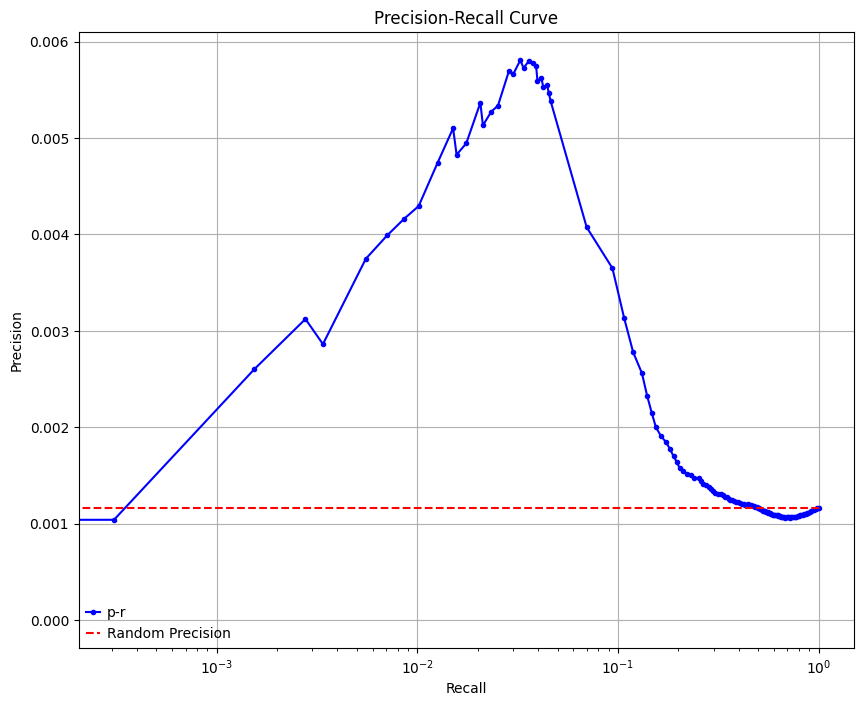

loading GT,  omnipath
intersection of 2589 genes
intersection pct: 0.7146011592602816
only tf:  False
using only tf:  0.7146011592602816
total true edges:  10398.0
precision:  0.0015512639937125918 
recall:  1.0 
random precision: 0.0015518634002016616


 98%|█████████▊| 126/128 [00:01<00:00, 83.49it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 83.29it/s]


Average Precision (AP):  0.002664625931944679
Area Under Precision-Recall Curve (AUPRC):  0.002652354098977331
EPR: 5.205662192349787


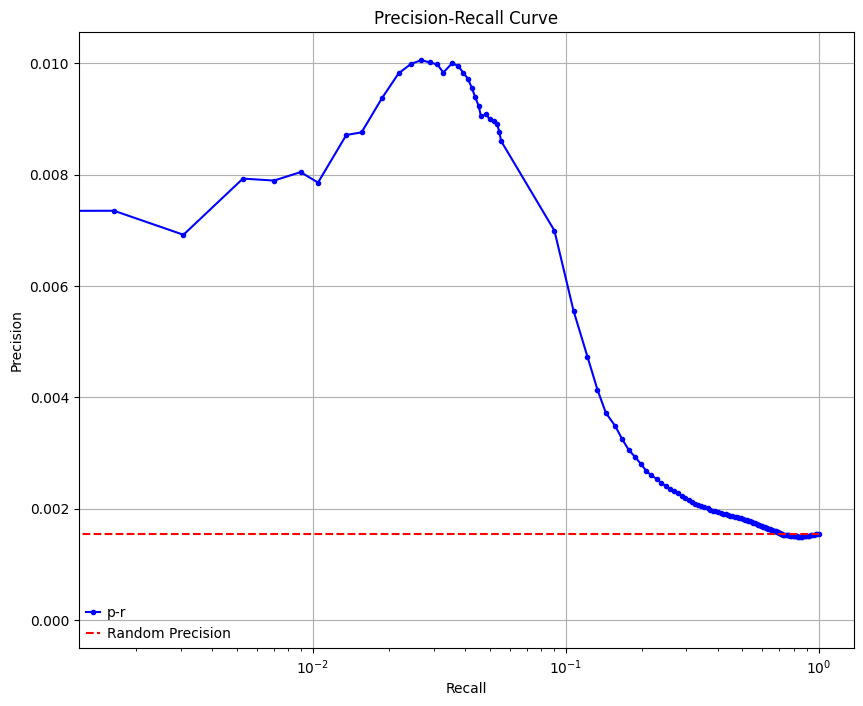

precision:  0.0025586115193505492 
recall:  1.0 
random precision: 0.002560163133370774


 84%|████████▍ | 108/128 [00:00<00:00, 1077.04it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1071.24it/s]


Average Precision (AP):  0.002857561452652857
Area Under Precision-Recall Curve (AUPRC):  0.0028424013691192504
EPR: 0.6410286259450608


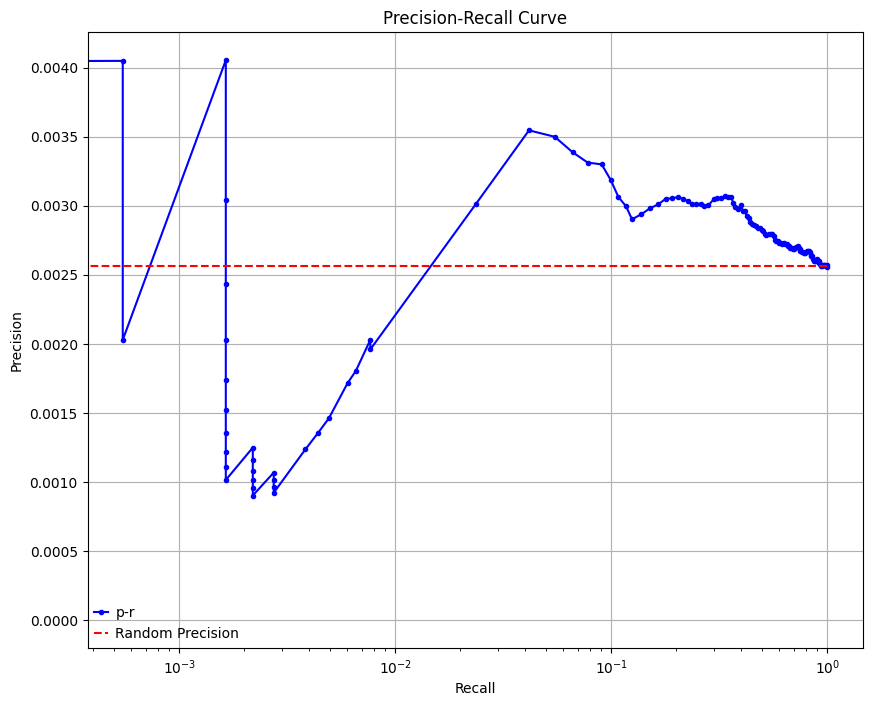

precision:  0.0025586115193505492 
recall:  1.0 
random precision: 0.002560163133370774


 84%|████████▎ | 107/128 [00:00<00:00, 1068.59it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 1064.41it/s]


Average Precision (AP):  0.002857561452652857
Area Under Precision-Recall Curve (AUPRC):  0.0028424013691192504
EPR: 0.6410286259450608


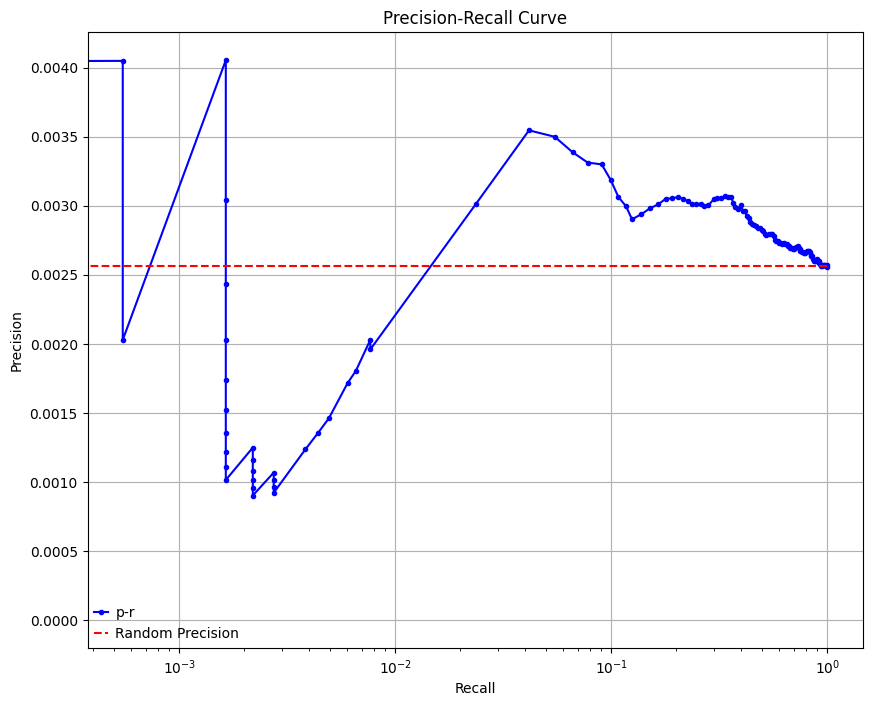

precision:  0.0033618192206767007 
recall:  1.0 
random precision: 0.0033629697406016416


 98%|█████████▊| 126/128 [00:02<00:00, 55.13it/s]/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 52.66it/s]


Average Precision (AP):  0.003760139750265865
Area Under Precision-Recall Curve (AUPRC):  0.0037560807680880864
EPR: 1.6201566184222929


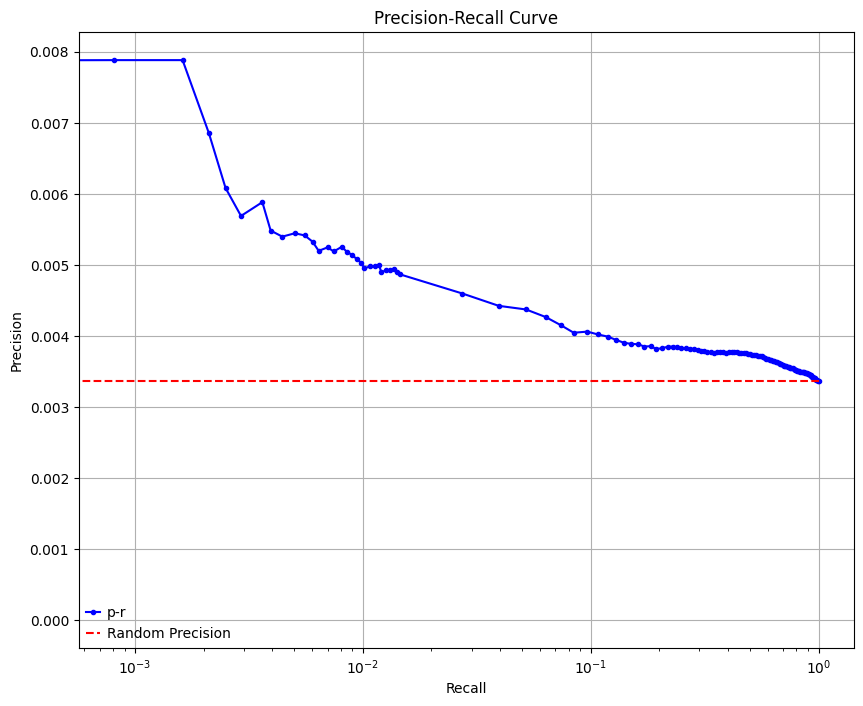

precision:  0.0005267574511549654 
recall:  1.0 
random precision: 0.0005269377240677494


 95%|█████████▍| 121/128 [00:01<00:00, 99.25it/s] /pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/bengrn/base.py:908: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:01<00:00, 103.73it/s]


Average Precision (AP):  0.0006571722354555803
Area Under Precision-Recall Curve (AUPRC):  0.0006512398985005839
EPR: 5.152282713294158


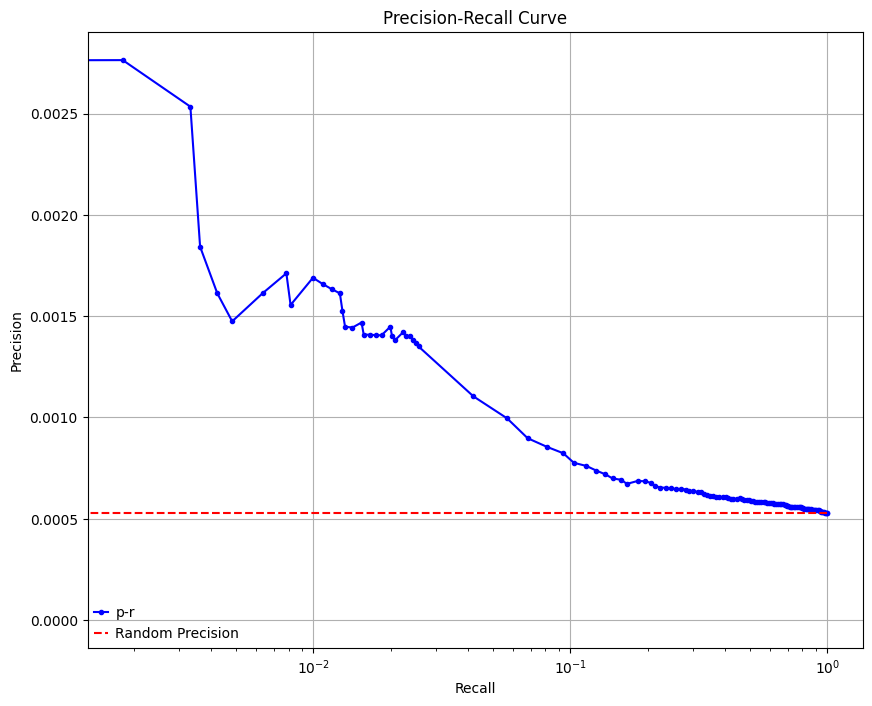

In [ ]:
metrics = {}
shapes = []
for celltype in adata.obs.celltype.value_counts().keys().tolist():
    grn_inferer = GNInfer(
        how="most var within",  # most expr
        preprocess="softmax",
        head_agg="mean",
        filtration="none",
        num_genes=4000,
        max_cells=1024,
        num_workers=8,
        batch_size=16,
        precomp_attn=False,
        cell_type_col="celltype",
    )
    grn = grn_inferer(model, adata, cell_type=celltype)
    grn.varp["GRN"][np.isnan(grn.varp["GRN"])] = 0
    grn.var.index = make_index_unique(grn.var["symbol"].astype(str))
    grn.varp["GRN"] = grn.varp["GRN"].T
    metrics[celltype + "_collectri"] = BenGRN(grn).compare_to(to="collectri")
    metrics[celltype + "_omnipath"] = BenGRN(grn).compare_to(to="omnipath")
    metrics[celltype + "_cellmap"] = BenGRN(grn).compare_to(gt_cm)
    metrics[celltype + "_gwps"] = BenGRN(grn).compare_to(gt_cm)
    metrics[celltype + "_interact"] = BenGRN(grn).compare_to(gt_inter)
    metrics[celltype + "_interact_hq"] = BenGRN(grn).compare_to(gt_inter_high_qual)
    del grn
# grn.varp["all"] = grn.varp["GRN"]
# grn.varp["GRN"] = grn.varp["GRN"][:, :, :].mean(-1)
# metrics[celltype + "_scprint_mean"] = BenGRN(grn).scprint_benchmark()

In [16]:
# most var across, full
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 4.320847454189799 0.001650089507826676
omnipath 2.161961011485835 0.0022005348151650124
cellmap 0.7579036152773526 0.00279858487990163
gwps 4.393426476008669 0.05303653714649336
interact 0.7885126112275245 0.0032431919506751674
interact 1.3165039188215408 0.0007380336918651627


In [ ]:
# no zero expr most var across, full
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 2.946032355129409 0.002094824186664233
omnipath 2.7240708744721527 0.002766940004414173
cellmap 0.5052690768515684 0.0028969264816182203
gwps 6.255797196027438 0.07189889987374425
interact 2.3880667654319314 0.003625986726765378
interact 9.654362071357966 0.0010260613477399562


In [ ]:
# no zero expr second trial, full
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 6.391822622152974 0.0026499323091102815
omnipath 11.786240962326248 0.002825303653759943
cellmap 1.5208244405146656 0.0029901568828903415
gwps 1.9368401547916452 0.02477496894268167
interact 1.3093877841006418 0.003950697092027391
interact 11.32344314936535 0.0005978302259696873


In [ ]:
# no zero expr, full
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 6.015833056143975 0.002604055862554985
omnipath 11.092932670424705 0.002789710383641038
cellmap 1.6898049339051837 0.0030508892757604446
gwps 3.365786084209938 0.03307093983753216
interact 1.3778525048379302 0.004175442762947657
interact 15.31995249620018 0.0006296682248338563


In [ ]:
# max most var within, full
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 2.4223730795878544 0.0017729955048933004
omnipath 1.314072511477024 0.002161736784490282
cellmap 1.0378315416535224 0.0025352133717579115
gwps 3.2769448126414873 0.05856635319675267
interact 1.5962985773386713 0.0038399127586959555
interact 2.567721870436926 0.0008905285981570997


In [ ]:
# mean full
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 6.7678121881619715 0.002635528851595563
omnipath 12.01734372629343 0.0028207894582880063
cellmap 1.5208244405146656 0.0030141050792928887
gwps 3.3460492619804034 0.032997567275140895
interact 1.3607363246536082 0.004176705484362731
interact 15.31995249620018 0.0006371698945342159


In [ ]:
# less cells
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 1.695661155711498 0.00181250742174925
omnipath 1.415155012359872 0.0023906906948043326
cellmap 1.0378315416535224 0.0026622182250509623
gwps 5.032339607614996 0.07293228734948903
interact 2.7441986778968173 0.004182887096974328
interact 3.2096523380461575 0.001013204125433611


In [ ]:
# more genes
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 0.7795931067176785 0.001626955095128026
omnipath 1.4136550849371263 0.0021280710909285278
cellmap 0.9890787726587984 0.0025631016217331727
gwps 5.039374243159614 0.060350320698679814
interact 2.1219004919374047 0.003919617245090371
interact 5.927645002142037 0.0008990599629006808


In [ ]:
# most expr
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 0.9918788577397826 0.002050403690883833
omnipath 1.1160264447330215 0.003021266229591356
cellmap 1.4443264095621609 0.0027797259350693768
gwps 2.7120910456155856 0.06918387763206227
interact 1.5280781386541193 0.004826298411995087
interact 1.9205865623689202 0.0012705638404502053


In [ ]:
interact best #(most expr AUPRC) # (mean full #EPR)
interact #(most expr) # (most var across)
gwps # (most var across)
cellmap #(most var within) # (mean full)
omnipath # (mean full)
collectri #(mean full)

In [ ]:
# within
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 2.89554375 0.0023501150639435595
omnipath 5.016505190311419 0.002239796342907146
cellmap 2.4469455895622545 0.002954973537836676
gwps 3.219736432055241 0.032151210471834335
interact 1.286258947175577 0.003832185953245134
interact 0.0 0.0005739554645104968


In [ ]:
# across
for k, v in metrics.items():
    print(k.split("_")[1], float(v["epr"]), float(v["auprc"]))

collectri 1.2111865397939272 0.0018516594378383262
omnipath 1.364613761918448 0.002451264598245648
cellmap 1.383775388871363 0.0026919804270312195
gwps 4.8764430894113096 0.06884667790676557
interact 2.3496080183299544 0.004083259545637848
interact 5.135443740873852 0.0009764047028928342


In [ ]:
# scPRINT-V1
metrics_v1 = {
    "Loop of Henle_collectri": {
        "precision": 0.0016351735562295604,
        "recall": 1.0,
        "rand_precision": 0.0016360646589849987,
        "auprc": 0.0022197900302843732,
        "ap": 0.0022256980810455725,
        "epr": 0.3326684252434588,
        "odd_ratio": 0.3319414185885892,
    },
    "Loop of Henle_omnipath": {
        "precision": 0.001963606529092425,
        "recall": 1.0,
        "rand_precision": 0.001964338671720722,
        "auprc": 0.002999505803702939,
        "ap": 0.003003267941393817,
        "epr": 1.0084302200382411,
        "odd_ratio": 1.0084637183606127,
    },
    "Loop of Henle_cellmap": {
        "precision": 0.002768556216724084,
        "recall": 1.0,
        "rand_precision": 0.0027703435351338476,
        "auprc": 0.00299428343667702,
        "ap": 0.002998483556081243,
        "epr": 0.0,
        "odd_ratio": 0.0,
    },
    "Loop of Henle_gwps": {
        "precision": 0.002768556216724084,
        "recall": 1.0,
        "rand_precision": 0.0027703435351338476,
        "auprc": 0.00299428343667702,
        "ap": 0.002998483556081243,
        "epr": 0.0,
        "odd_ratio": 0.0,
    },
    "Loop of Henle_interact": {
        "precision": 0.002988486995568852,
        "recall": 1.0,
        "rand_precision": 0.00298950626125629,
        "auprc": 0.0035738090156042885,
        "ap": 0.0035781896041834228,
        "epr": 2.7850104144140593,
        "odd_ratio": 2.815109085267852,
    },
    "Loop of Henle_interact_hq": {
        "precision": 0.0005347732521561882,
        "recall": 1.0,
        "rand_precision": 0.0005349556441248636,
        "auprc": 0.0008289610125244967,
        "ap": 0.0008293163777116502,
        "epr": 7.243242974318198,
        "odd_ratio": 7.291908452744588,
    },
    "Epithelial cell_collectri": {
        "precision": 0.0014307207836572373,
        "recall": 1.0,
        "rand_precision": 0.0014315147463562702,
        "auprc": 0.0018889158318145657,
        "ap": 0.0018912488079074969,
        "epr": 0.0,
        "odd_ratio": 0.0,
    },
    "Epithelial cell_omnipath": {
        "precision": 0.0015545019752171024,
        "recall": 1.0,
        "rand_precision": 0.0015550850592288116,
        "auprc": 0.002529945576219922,
        "ap": 0.002536731886220471,
        "epr": 1.1631575318695417,
        "odd_ratio": 1.1637493787832305,
    },
    "Epithelial cell_cellmap": {
        "precision": 0.0025700488783087618,
        "recall": 1.0,
        "rand_precision": 0.0025714878754410737,
        "auprc": 0.002938111306394351,
        "ap": 0.0029517818138190786,
        "epr": 0.5812853815829946,
        "odd_ratio": 0.5800308066501727,
    },
    "Epithelial cell_gwps": {
        "precision": 0.0025700488783087618,
        "recall": 1.0,
        "rand_precision": 0.0025714878754410737,
        "auprc": 0.002938111306394351,
        "ap": 0.0029517818138190786,
        "epr": 0.5812853815829946,
        "odd_ratio": 0.5800308066501727,
    },
    "Epithelial cell_interact": {
        "precision": 0.003325516866811766,
        "recall": 1.0,
        "rand_precision": 0.0033266205896351356,
        "auprc": 0.0037613901295581956,
        "ap": 0.003777126860922326,
        "epr": 2.3703720934135766,
        "odd_ratio": 2.3922420989296693,
    },
    "Epithelial cell_interact_hq": {
        "precision": 0.0005029854669496383,
        "recall": 1.0,
        "rand_precision": 0.0005031524053721241,
        "auprc": 0.0007429638483895612,
        "ap": 0.00075507091505666,
        "epr": 9.452886476520648,
        "odd_ratio": 9.533871752818067,
    },
    "Intercalated cell_collectri": {
        "precision": 0.0016556420841934072,
        "recall": 1.0,
        "rand_precision": 0.0016565876250752994,
        "auprc": 0.002242334731636479,
        "ap": 0.002245131342712549,
        "epr": 0.47512832057213295,
        "odd_ratio": 0.47430109977148915,
    },
    "Intercalated cell_omnipath": {
        "precision": 0.0017150386922127202,
        "recall": 1.0,
        "rand_precision": 0.0017156803078850781,
        "auprc": 0.0028035382304503337,
        "ap": 0.002805581270491533,
        "epr": 1.283307313563974,
        "odd_ratio": 1.2845589868149345,
    },
    "Intercalated cell_cellmap": {
        "precision": 0.0022007547734210786,
        "recall": 1.0,
        "rand_precision": 0.0022020663078510076,
        "auprc": 0.0024536909920569697,
        "ap": 0.0024599799741398865,
        "epr": 0.0,
        "odd_ratio": 0.0,
    },
    "Intercalated cell_gwps": {
        "precision": 0.0022007547734210786,
        "recall": 1.0,
        "rand_precision": 0.0022020663078510076,
        "auprc": 0.0024536909920569697,
        "ap": 0.0024599799741398865,
        "epr": 0.0,
        "odd_ratio": 0.0,
    },
    "Intercalated cell_interact": {
        "precision": 0.0033202743561688963,
        "recall": 1.0,
        "rand_precision": 0.0033214075556078615,
        "auprc": 0.0038363061191326858,
        "ap": 0.003856707322822372,
        "epr": 2.7097159008698064,
        "odd_ratio": 2.740911539266517,
    },
    "Intercalated cell_interact_hq": {
        "precision": 0.000577479560761717,
        "recall": 1.0,
        "rand_precision": 0.000577676652761977,
        "auprc": 0.0008631113501905528,
        "ap": 0.0008716646336338009,
        "epr": 8.99627242648995,
        "odd_ratio": 9.080037079571015,
    },
    "Endothelial cell (APC)_collectri": {
        "precision": 0.001200845478618044,
        "recall": 1.0,
        "rand_precision": 0.0012015312841455242,
        "auprc": 0.0017865491439520076,
        "ap": 0.0017966800025785259,
        "epr": 0.22579253846953276,
        "odd_ratio": 0.22537228744644852,
    },
    "Endothelial cell (APC)_omnipath": {
        "precision": 0.0014393562374743463,
        "recall": 1.0,
        "rand_precision": 0.001439881549969775,
        "auprc": 0.0023910141635906006,
        "ap": 0.002399625222260653,
        "epr": 1.9266734937199443,
        "odd_ratio": 1.931836489546003,
    },
    "Endothelial cell (APC)_cellmap": {
        "precision": 0.0024410482902542468,
        "recall": 1.0,
        "rand_precision": 0.0024424021717241603,
        "auprc": 0.0027382348650563898,
        "ap": 0.0027453811374845293,
        "epr": 0.5657756520407083,
        "odd_ratio": 0.5645730926866465,
    },
    "Endothelial cell (APC)_gwps": {
        "precision": 0.0024410482902542468,
        "recall": 1.0,
        "rand_precision": 0.0024424021717241603,
        "auprc": 0.0027382348650563898,
        "ap": 0.0027453811374845293,
        "epr": 0.5657756520407083,
        "odd_ratio": 0.5645730926866465,
    },
    "Endothelial cell (APC)_interact": {
        "precision": 0.003367953925015091,
        "recall": 1.0,
        "rand_precision": 0.003369066930277819,
        "auprc": 0.003765486763053893,
        "ap": 0.003781589580348783,
        "epr": 2.2724588494065783,
        "odd_ratio": 2.292168970209985,
    },
    "Endothelial cell (APC)_interact_hq": {
        "precision": 0.0005464326552273234,
        "recall": 1.0,
        "rand_precision": 0.0005466132344260104,
        "auprc": 0.0007089164672483043,
        "ap": 0.0007198767218621724,
        "epr": 8.371628750346439,
        "odd_ratio": 8.439560462864028,
    },
    "Monocyte_collectri": {
        "precision": 0.0016847018347605363,
        "recall": 1.0,
        "rand_precision": 0.0016856870405118584,
        "auprc": 0.0020307934682426572,
        "ap": 0.002051908737089973,
        "epr": 0.8419727268960046,
        "odd_ratio": 0.8415231930737715,
    },
    "Monocyte_omnipath": {
        "precision": 0.0016860794417895132,
        "recall": 1.0,
        "rand_precision": 0.00168670951631933,
        "auprc": 0.002790592528548713,
        "ap": 0.002813753233971633,
        "epr": 3.5327867734664746,
        "odd_ratio": 3.563243392998596,
    },
    "Monocyte_cellmap": {
        "precision": 0.00243065695919019,
        "recall": 1.0,
        "rand_precision": 0.002432002837905135,
        "auprc": 0.0026958545667712603,
        "ap": 0.0026998406705982005,
        "epr": 1.1533905489909888,
        "odd_ratio": 1.154254719388512,
    },
    "Monocyte_gwps": {
        "precision": 0.00243065695919019,
        "recall": 1.0,
        "rand_precision": 0.002432002837905135,
        "auprc": 0.0026958545667712603,
        "ap": 0.0026998406705982005,
        "epr": 1.1533905489909888,
        "odd_ratio": 1.154254719388512,
    },
    "Monocyte_interact": {
        "precision": 0.0037083348454805495,
        "recall": 1.0,
        "rand_precision": 0.0037095591224186415,
        "auprc": 0.004199170086279234,
        "ap": 0.004236307950886452,
        "epr": 2.246448448003163,
        "odd_ratio": 2.2674851812192327,
    },
    "Monocyte_interact_hq": {
        "precision": 0.000681921525485882,
        "recall": 1.0,
        "rand_precision": 0.0006821466563955834,
        "auprc": 0.0009095565037949163,
        "ap": 0.0009629662739041072,
        "epr": 11.036484137634218,
        "odd_ratio": 11.18932734075388,
    },
    "Macrophage_collectri": {
        "precision": 0.001525422824805722,
        "recall": 1.0,
        "rand_precision": 0.0015263040627172214,
        "auprc": 0.0021029682629947477,
        "ap": 0.0021100277651139635,
        "epr": 0.0,
        "odd_ratio": 0.0,
    },
    "Macrophage_omnipath": {
        "precision": 0.0016541599379445494,
        "recall": 1.0,
        "rand_precision": 0.0016547829737027205,
        "auprc": 0.002823607533856724,
        "ap": 0.002827658142593077,
        "epr": 2.3822270302253594,
        "odd_ratio": 2.3931894775382876,
    },
    "Macrophage_cellmap": {
        "precision": 0.002460724720713958,
        "recall": 1.0,
        "rand_precision": 0.00246215371300241,
        "auprc": 0.0028222143569289577,
        "ap": 0.0029117001517864807,
        "epr": 1.4358784817875727,
        "odd_ratio": 1.4389768720093281,
    },
    "Macrophage_gwps": {
        "precision": 0.002460724720713958,
        "recall": 1.0,
        "rand_precision": 0.00246215371300241,
        "auprc": 0.0028222143569289577,
        "ap": 0.0029117001517864807,
        "epr": 1.4358784817875727,
        "odd_ratio": 1.4389768720093281,
    },
    "Macrophage_interact": {
        "precision": 0.003513577168753223,
        "recall": 1.0,
        "rand_precision": 0.003514752278174211,
        "auprc": 0.0038577522992340094,
        "ap": 0.0038708313788098636,
        "epr": 1.8816047057463505,
        "odd_ratio": 1.893382173780915,
    },
    "Macrophage_interact_hq": {
        "precision": 0.0006291519485994214,
        "recall": 1.0,
        "rand_precision": 0.0006293623673113276,
        "auprc": 0.0007265329764612701,
        "ap": 0.0007294334219004334,
        "epr": 3.441681763088272,
        "odd_ratio": 3.4522939132656587,
    },
    "Smooth muscle cell_collectri": {
        "precision": 0.0015214809524205,
        "recall": 1.0,
        "rand_precision": 0.001522358392416129,
        "auprc": 0.002233304005423953,
        "ap": 0.0022415336324816742,
        "epr": 2.438184340496939,
        "odd_ratio": 2.448920556963511,
    },
    "Smooth muscle cell_omnipath": {
        "precision": 0.0019526530612244898,
        "recall": 1.0,
        "rand_precision": 0.001953397212543554,
        "auprc": 0.003033932343429758,
        "ap": 0.003036832567610206,
        "epr": 4.261316158945939,
        "odd_ratio": 4.316296361522517,
    },
    "Smooth muscle cell_cellmap": {
        "precision": 0.002630950135194617,
        "recall": 1.0,
        "rand_precision": 0.0026325227294176864,
        "auprc": 0.0032564781314774697,
        "ap": 0.003261316866901108,
        "epr": 3.63158476797707,
        "odd_ratio": 3.6826327499590046,
    },
    "Smooth muscle cell_gwps": {
        "precision": 0.002630950135194617,
        "recall": 1.0,
        "rand_precision": 0.0026325227294176864,
        "auprc": 0.0032564781314774697,
        "ap": 0.003261316866901108,
        "epr": 3.63158476797707,
        "odd_ratio": 3.6826327499590046,
    },
    "Smooth muscle cell_interact": {
        "precision": 0.0032318697180226475,
        "recall": 1.0,
        "rand_precision": 0.0032329761438076605,
        "auprc": 0.003718839125484954,
        "ap": 0.003769170547690047,
        "epr": 2.4551306545512124,
        "odd_ratio": 2.4785084692517327,
    },
    "Smooth muscle cell_interact_hq": {
        "precision": 0.000547190603250755,
        "recall": 1.0,
        "rand_precision": 0.0005473779331388929,
        "auprc": 0.0007419965905188435,
        "ap": 0.0008774239534851701,
        "epr": 8.976055665074009,
        "odd_ratio": 9.055014535294475,
    },
    "Dendritic cell_collectri": {
        "precision": 0.001863522261857577,
        "recall": 1.0,
        "rand_precision": 0.0018645938675285704,
        "auprc": 0.002248474924593263,
        "ap": 0.0022541675147945395,
        "epr": 0.09505668543301046,
        "odd_ratio": 0.09473581199715998,
    },
    "Dendritic cell_omnipath": {
        "precision": 0.0017944319338525608,
        "recall": 1.0,
        "rand_precision": 0.0017951121582399196,
        "auprc": 0.0026522662034466245,
        "ap": 0.0026569161960756267,
        "epr": 1.6047417163907447,
        "odd_ratio": 1.6082409780420055,
    },
    "Dendritic cell_cellmap": {
        "precision": 0.0025644517066085695,
        "recall": 1.0,
        "rand_precision": 0.0025660240252514933,
        "auprc": 0.003071815327963443,
        "ap": 0.0030789636505841236,
        "epr": 0.4057344764203747,
        "odd_ratio": 0.4044951325992971,
    },
    "Dendritic cell_gwps": {
        "precision": 0.0025644517066085695,
        "recall": 1.0,
        "rand_precision": 0.0025660240252514933,
        "auprc": 0.003071815327963443,
        "ap": 0.0030789636505841236,
        "epr": 0.4057344764203747,
        "odd_ratio": 0.4044951325992971,
    },
    "Dendritic cell_interact": {
        "precision": 0.003302037721925473,
        "recall": 1.0,
        "rand_precision": 0.003303175178943015,
        "auprc": 0.003611360297909579,
        "ap": 0.0036260942204121883,
        "epr": 1.9270816100167727,
        "odd_ratio": 1.9389979226312095,
    },
    "Dendritic cell_interact_hq": {
        "precision": 0.0005689515475611732,
        "recall": 1.0,
        "rand_precision": 0.0005691475350043566,
        "auprc": 0.0006876530203248743,
        "ap": 0.0006958272723041252,
        "epr": 5.504742348193061,
        "odd_ratio": 5.533102367346939,
    },
    "Sinusoidal endothelial cell_collectri": {
        "precision": 0.0011663718726676602,
        "recall": 1.0,
        "rand_precision": 0.0011670711363802905,
        "auprc": 0.0016234416698115465,
        "ap": 0.001621648471501718,
        "epr": 2.9009860836504284,
        "odd_ratio": 2.9139239253140117,
    },
    "Sinusoidal endothelial cell_omnipath": {
        "precision": 0.0015512639937125918,
        "recall": 1.0,
        "rand_precision": 0.0015518634002016616,
        "auprc": 0.002652354098977331,
        "ap": 0.002664625931944679,
        "epr": 5.205662192349787,
        "odd_ratio": 5.274445246485486,
    },
    "Sinusoidal endothelial cell_cellmap": {
        "precision": 0.0025586115193505492,
        "recall": 1.0,
        "rand_precision": 0.002560163133370774,
        "auprc": 0.0028424013691192504,
        "ap": 0.002857561452652857,
        "epr": 0.6410286259450608,
        "odd_ratio": 0.6398474760743104,
    },
    "Sinusoidal endothelial cell_gwps": {
        "precision": 0.0025586115193505492,
        "recall": 1.0,
        "rand_precision": 0.002560163133370774,
        "auprc": 0.0028424013691192504,
        "ap": 0.002857561452652857,
        "epr": 0.6410286259450608,
        "odd_ratio": 0.6398474760743104,
    },
    "Sinusoidal endothelial cell_interact": {
        "precision": 0.0033618192206767007,
        "recall": 1.0,
        "rand_precision": 0.0033629697406016416,
        "auprc": 0.0037560807680880864,
        "ap": 0.003760139750265865,
        "epr": 1.6201566184222929,
        "odd_ratio": 1.6269701467749818,
    },
    "Sinusoidal endothelial cell_interact_hq": {
        "precision": 0.0005267574511549654,
        "recall": 1.0,
        "rand_precision": 0.0005269377240677494,
        "auprc": 0.0006512398985005839,
        "ap": 0.0006571722354555803,
        "epr": 5.152282713294158,
        "odd_ratio": 5.17492119591174,
    },
}

In [ ]:
# scPRINT-V2
metrics_v2 = {
    "Loop of Henle_collectri": {
        "precision": 0.0023702325319690013,
        "recall": 0.4345983787767133,
        "rand_precision": 0.0016359932992993681,
        "auprc": 0.002524958561305613,
        "ap": 0.002607661472796709,
        "epr": 1.8017669780699872,
        "odd_ratio": 1.8065146626068156,
    },
    "Loop of Henle_omnipath": {
        "precision": 0.0024983785322948908,
        "recall": 0.34248951857741794,
        "rand_precision": 0.0019456495169911713,
        "auprc": 0.002666034936748366,
        "ap": 0.0027245312745705426,
        "epr": 2.972197092985209,
        "odd_ratio": 2.995206343822165,
    },
    "Loop of Henle_cellmap": {
        "precision": 0.0027501369947199416,
        "recall": 0.307032590051458,
        "rand_precision": 0.002762858587135094,
        "auprc": 0.0028319857944663056,
        "ap": 0.002757707209727731,
        "epr": 1.2416602675187096,
        "odd_ratio": 1.2433268851160728,
    },
    "Loop of Henle_interact": {
        "precision": 0.0031227963702145658,
        "recall": 0.28655412115193646,
        "rand_precision": 0.0029842561668897995,
        "auprc": 0.0031337323811923084,
        "ap": 0.003161301115776045,
        "epr": 2.0897487454748243,
        "odd_ratio": 2.1034690581179505,
    },
    "Loop of Henle_interact_hq": {
        "precision": 0.0005685165851792895,
        "recall": 0.30210558437595364,
        "rand_precision": 0.0005284844575252994,
        "auprc": 0.000721564165947526,
        "ap": 0.0007789734257534768,
        "epr": 18.477419441351017,
        "odd_ratio": 18.82382007640058,
    },
    "Epithelial cell_collectri": {
        "precision": 0.002115926934691915,
        "recall": 0.3931847968545216,
        "rand_precision": 0.0014392279852820232,
        "auprc": 0.0021102309997497117,
        "ap": 0.0021670843033546336,
        "epr": 1.821276410572646,
        "odd_ratio": 1.8255989105328017,
    },
    "Epithelial cell_omnipath": {
        "precision": 0.002176638734901555,
        "recall": 0.3039659794767496,
        "rand_precision": 0.0015432451033319371,
        "auprc": 0.002107069130967752,
        "ap": 0.0021701778547424375,
        "epr": 1.9169387696201223,
        "odd_ratio": 1.9223881105151066,
    },
    "Epithelial cell_cellmap": {
        "precision": 0.002488083067486174,
        "recall": 0.20591233435270132,
        "rand_precision": 0.002557244744744745,
        "auprc": 0.002634486801512898,
        "ap": 0.002772169837712454,
        "epr": 1.39516875683865,
        "odd_ratio": 1.3980036760617736,
    },
    "Epithelial cell_interact": {
        "precision": 0.003017311673993117,
        "recall": 0.19331169270305,
        "rand_precision": 0.0033225144336255447,
        "auprc": 0.0033650172233255947,
        "ap": 0.0033399280846183456,
        "epr": 1.9031133761000856,
        "odd_ratio": 1.9146436126182549,
    },
    "Epithelial cell_interact_hq": {
        "precision": 0.0005194827075438717,
        "recall": 0.2254722730042657,
        "rand_precision": 0.0004966417664830364,
        "auprc": 0.0006945652717673632,
        "ap": 0.0007824985594610337,
        "epr": 22.086183904895908,
        "odd_ratio": 22.556493246913874,
    },
    "Intercalated cell_collectri": {
        "precision": 0.0027529302408495627,
        "recall": 0.4332665330661323,
        "rand_precision": 0.0016548209344465403,
        "auprc": 0.0024960261307904125,
        "ap": 0.0026238710099513295,
        "epr": 1.332113204364641,
        "odd_ratio": 1.3335822868177294,
    },
    "Intercalated cell_omnipath": {
        "precision": 0.0023658072102420934,
        "recall": 0.32231473771856783,
        "rand_precision": 0.0016980209078544424,
        "auprc": 0.002211486310807193,
        "ap": 0.002300604524990032,
        "epr": 1.520112229539497,
        "odd_ratio": 1.522807670191625,
    },
    "Intercalated cell_cellmap": {
        "precision": 0.0022957944249568873,
        "recall": 0.26171637248934876,
        "rand_precision": 0.00221818397831229,
        "auprc": 0.002304929562904042,
        "ap": 0.002244096872041673,
        "epr": 2.1951027783818104,
        "odd_ratio": 2.2068265858653873,
    },
    "Intercalated cell_interact": {
        "precision": 0.003388352086445282,
        "recall": 0.24008849873318347,
        "rand_precision": 0.0033230202664748486,
        "auprc": 0.00346186734800524,
        "ap": 0.0034626471684037225,
        "epr": 2.2766079294149475,
        "odd_ratio": 2.296144976836893,
    },
    "Intercalated cell_interact_hq": {
        "precision": 0.0006458927541499103,
        "recall": 0.2718957871396896,
        "rand_precision": 0.0005751697252847194,
        "auprc": 0.0008531826442462714,
        "ap": 0.0009781816497010539,
        "epr": 23.612041223371566,
        "odd_ratio": 24.23896866067221,
    },
    "Endothelial cell (APC)_collectri": {
        "precision": 0.001784961284134141,
        "recall": 0.531897265948633,
        "rand_precision": 0.001193937527490898,
        "auprc": 0.002113630393304446,
        "ap": 0.0022073094851259695,
        "epr": 4.1635365092744685,
        "odd_ratio": 4.195224490276976,
    },
    "Endothelial cell (APC)_omnipath": {
        "precision": 0.0019620580880116705,
        "recall": 0.40682439438212836,
        "rand_precision": 0.0014239943518067372,
        "auprc": 0.002299108563880585,
        "ap": 0.002483436391615884,
        "epr": 4.56737188934132,
        "odd_ratio": 4.614232300191913,
    },
    "Endothelial cell (APC)_cellmap": {
        "precision": 0.002646011368618613,
        "recall": 0.3189615206305053,
        "rand_precision": 0.002443312211577018,
        "auprc": 0.0026262655594060484,
        "ap": 0.00267446568632573,
        "epr": 1.5179619180385195,
        "odd_ratio": 1.5218254900555432,
    },
    "Endothelial cell (APC)_interact": {
        "precision": 0.0033913051130122587,
        "recall": 0.29110016420361245,
        "rand_precision": 0.0033766501922361885,
        "auprc": 0.003478766829930216,
        "ap": 0.003521231111713056,
        "epr": 1.7311975690315762,
        "odd_ratio": 1.739821764259858,
    },
    "Endothelial cell (APC)_interact_hq": {
        "precision": 0.0006027128602664683,
        "recall": 0.32512181916621546,
        "rand_precision": 0.0005470934291620644,
        "auprc": 0.0007284855910144797,
        "ap": 0.0007962668149089128,
        "epr": 19.79254319842622,
        "odd_ratio": 20.206235662891572,
    },
    "Monocyte_collectri": {
        "precision": 0.0027969429722937513,
        "recall": 0.4474716202270382,
        "rand_precision": 0.0016774573278399059,
        "auprc": 0.0023169232904228223,
        "ap": 0.002470067167742072,
        "epr": 2.7069324498035594,
        "odd_ratio": 2.722540229752135,
    },
    "Monocyte_omnipath": {
        "precision": 0.0026617514203081324,
        "recall": 0.3709023318688746,
        "rand_precision": 0.0016683976503728663,
        "auprc": 0.002354118054727489,
        "ap": 0.002528728271055905,
        "epr": 4.000576368645683,
        "odd_ratio": 4.041035998677798,
    },
    "Monocyte_cellmap": {
        "precision": 0.00259958932238193,
        "recall": 0.2967651195499297,
        "rand_precision": 0.0024328652377432866,
        "auprc": 0.002624117361881841,
        "ap": 0.0026412031601962356,
        "epr": 1.7343374459221277,
        "odd_ratio": 1.7405738293593795,
    },
    "Monocyte_interact": {
        "precision": 0.003827687905102404,
        "recall": 0.24534272748984953,
        "rand_precision": 0.0037169012033989183,
        "auprc": 0.0039160846144751784,
        "ap": 0.004002828597467673,
        "epr": 2.1525875723127457,
        "odd_ratio": 2.1712549105516517,
    },
    "Monocyte_interact_hq": {
        "precision": 0.0007727630472920277,
        "recall": 0.28294489218035285,
        "rand_precision": 0.0006798637133146073,
        "auprc": 0.0009275138125205232,
        "ap": 0.0010757238662229746,
        "epr": 14.73766488191717,
        "odd_ratio": 15.017150243077113,
    },
    "Macrophage_collectri": {
        "precision": 0.002489637146407138,
        "recall": 0.47710093374833257,
        "rand_precision": 0.0015230719324728552,
        "auprc": 0.0026802035008610223,
        "ap": 0.0027920129359065493,
        "epr": 1.6056571558605859,
        "odd_ratio": 1.608630365145199,
    },
    "Macrophage_omnipath": {
        "precision": 0.002740714345417992,
        "recall": 0.38227559607293127,
        "rand_precision": 0.00164117153867888,
        "auprc": 0.002896250013276017,
        "ap": 0.0029919991023338627,
        "epr": 5.287759635471478,
        "odd_ratio": 5.363159088616878,
    },
    "Macrophage_cellmap": {
        "precision": 0.002823066519119636,
        "recall": 0.29420809841107126,
        "rand_precision": 0.002453174667042208,
        "auprc": 0.0026873854991281343,
        "ap": 0.002733159252946667,
        "epr": 0.8357458922483469,
        "odd_ratio": 0.8350702976594179,
    },
    "Macrophage_interact": {
        "precision": 0.0036167992859926336,
        "recall": 0.23324362009144264,
        "rand_precision": 0.003524620282424501,
        "auprc": 0.003622094473128514,
        "ap": 0.0036170371941891006,
        "epr": 1.6375983018348947,
        "odd_ratio": 1.64502284334149,
    },
    "Macrophage_interact_hq": {
        "precision": 0.0007305598608606634,
        "recall": 0.27259439707673566,
        "rand_precision": 0.0006306205690455784,
        "auprc": 0.0007026913658396794,
        "ap": 0.0007369537512007249,
        "epr": 4.635535939208446,
        "odd_ratio": 4.656884770880116,
    },
    "Smooth muscle cell_collectri": {
        "precision": 0.002235943391071526,
        "recall": 0.4539605058797426,
        "rand_precision": 0.0015190397323092708,
        "auprc": 0.002329708546783732,
        "ap": 0.0024026075459283305,
        "epr": 3.0673448382859707,
        "odd_ratio": 3.0867455773139953,
    },
    "Smooth muscle cell_omnipath": {
        "precision": 0.002619890336327631,
        "recall": 0.34552629581847155,
        "rand_precision": 0.0019321307015964383,
        "auprc": 0.002662694666318261,
        "ap": 0.002850968750756855,
        "epr": 3.417167011754984,
        "odd_ratio": 3.4494041953193526,
    },
    "Smooth muscle cell_cellmap": {
        "precision": 0.002755236024711023,
        "recall": 0.3090294543698696,
        "rand_precision": 0.0026352623810250927,
        "auprc": 0.0031113700749068793,
        "ap": 0.003118717095724886,
        "epr": 2.9316763351061463,
        "odd_ratio": 2.9618730649238403,
    },
    "Smooth muscle cell_interact": {
        "precision": 0.0032840127233416806,
        "recall": 0.2606129900785601,
        "rand_precision": 0.003235111067413639,
        "auprc": 0.0034352712230006745,
        "ap": 0.0034230641828120025,
        "epr": 2.3143512275156044,
        "odd_ratio": 2.3342560713754548,
    },
    "Smooth muscle cell_interact_hq": {
        "precision": 0.0005850586978421694,
        "recall": 0.28111273792093705,
        "rand_precision": 0.0005457001068709316,
        "auprc": 0.0007110376164424695,
        "ap": 0.0007475210849634519,
        "epr": 10.732113297419662,
        "odd_ratio": 10.847115115575404,
    },
    "Dendritic cell_collectri": {
        "precision": 0.002965273166958037,
        "recall": 0.4385585585585586,
        "rand_precision": 0.001859760020588046,
        "auprc": 0.002689943344871653,
        "ap": 0.002812640332267445,
        "epr": 1.065719211102995,
        "odd_ratio": 1.0659804962242982,
    },
    "Dendritic cell_omnipath": {
        "precision": 0.0030550401153399457,
        "recall": 0.3738157464880758,
        "rand_precision": 0.0017775842044134727,
        "auprc": 0.002754307569307018,
        "ap": 0.0029347536262986367,
        "epr": 3.537832129686679,
        "odd_ratio": 3.57005558969555,
    },
    "Dendritic cell_cellmap": {
        "precision": 0.0029735774906977717,
        "recall": 0.29868766404199476,
        "rand_precision": 0.0025580495979632286,
        "auprc": 0.002936145096929038,
        "ap": 0.0030539067374522784,
        "epr": 1.4364618595903857,
        "odd_ratio": 1.4396872199786588,
    },
    "Dendritic cell_interact": {
        "precision": 0.0033709825595413206,
        "recall": 0.21839332748024584,
        "rand_precision": 0.003318854825111794,
        "auprc": 0.0034605066309664903,
        "ap": 0.0033881506050994904,
        "epr": 1.7525640659995996,
        "odd_ratio": 1.7613956307240393,
    },
    "Dendritic cell_interact_hq": {
        "precision": 0.0006880807738093497,
        "recall": 0.2709473078030521,
        "rand_precision": 0.000569395041131537,
        "auprc": 0.0006999215084842667,
        "ap": 0.0007334973927885827,
        "epr": 4.551180349019614,
        "odd_ratio": 4.569657336563745,
    },
    "Sinusoidal endothelial cell_collectri": {
        "precision": 0.0017658221857402875,
        "recall": 0.3575243480992774,
        "rand_precision": 0.0011599888046320834,
        "auprc": 0.001738410563422878,
        "ap": 0.0018526632495428374,
        "epr": 7.583463398124403,
        "odd_ratio": 7.700835792556277,
    },
    "Sinusoidal endothelial cell_omnipath": {
        "precision": 0.0021362711662851392,
        "recall": 0.2478809383008082,
        "rand_precision": 0.00153195683704817,
        "auprc": 0.002081586459733848,
        "ap": 0.0021644951089560193,
        "epr": 6.3693308331127225,
        "odd_ratio": 6.475667587183475,
    },
    "Sinusoidal endothelial cell_cellmap": {
        "precision": 0.0026401006538374276,
        "recall": 0.21180364037506894,
        "rand_precision": 0.0025693352040020976,
        "auprc": 0.002698925223064425,
        "ap": 0.0027988774231708946,
        "epr": 2.1467497868096714,
        "odd_ratio": 2.159505526162872,
    },
    "Sinusoidal endothelial cell_interact": {
        "precision": 0.003612750193051451,
        "recall": 0.19709196914216645,
        "rand_precision": 0.0033598258991705842,
        "auprc": 0.003551392048684204,
        "ap": 0.003650875884245976,
        "epr": 2.317250840000773,
        "odd_ratio": 2.3380039554893197,
    },
    "Sinusoidal endothelial cell_interact_hq": {
        "precision": 0.0006316058982665173,
        "recall": 0.22845752836553204,
        "rand_precision": 0.0005246842964451795,
        "auprc": 0.0006262622851117398,
        "ap": 0.0006872733291032303,
        "epr": 7.597915991364024,
        "odd_ratio": 7.650837518048242,
    },
}

In [45]:
show = {}
for k, v in metrics_v1.items():
    gt = k.split("_")[-1]
    if gt + "_auprc" in show:
        show[gt + "_auprc"].append(v["auprc"] / v["rand_precision"])
    else:
        show[gt + "_auprc"] = [v["auprc"] / v["rand_precision"]]
    if gt + "_odd_ratio" in show:
        show[gt + "_odd_ratio"].append(v["odd_ratio"])
    else:
        show[gt + "_odd_ratio"] = [v["odd_ratio"]]
    print(k)

Loop of Henle_collectri
Loop of Henle_omnipath
Loop of Henle_cellmap
Loop of Henle_gwps
Loop of Henle_interact
Loop of Henle_interact_hq
Epithelial cell_collectri
Epithelial cell_omnipath
Epithelial cell_cellmap
Epithelial cell_gwps
Epithelial cell_interact
Epithelial cell_interact_hq
Intercalated cell_collectri
Intercalated cell_omnipath
Intercalated cell_cellmap
Intercalated cell_gwps
Intercalated cell_interact
Intercalated cell_interact_hq
Endothelial cell (APC)_collectri
Endothelial cell (APC)_omnipath
Endothelial cell (APC)_cellmap
Endothelial cell (APC)_gwps
Endothelial cell (APC)_interact
Endothelial cell (APC)_interact_hq
Monocyte_collectri
Monocyte_omnipath
Monocyte_cellmap
Monocyte_gwps
Monocyte_interact
Monocyte_interact_hq
Macrophage_collectri
Macrophage_omnipath
Macrophage_cellmap
Macrophage_gwps
Macrophage_interact
Macrophage_interact_hq
Smooth muscle cell_collectri
Smooth muscle cell_omnipath
Smooth muscle cell_cellmap
Smooth muscle cell_gwps
Smooth muscle cell_interact


In [ ]:
df = pd.DataFrame(
    {i: v for i, v in show.items() if "_odd_ratio" in i},
    index=[
        "Loop of Henle",
        "Epithelial cell",
        "Intercalated cell",
        "Endothelial cell (APC)",
        "Monocyte",
        "Macrophage",
        "Smooth muscle cell",
        "Dendritic cell",
        "Sinusoidal endothelial cell",
    ],
)

# Clean column names (remove '_auprc' suffix)
df.columns = [col.replace("_odd_ratio", "") for col in df.columns]

# Long format for seaborn
df_long = df.reset_index().melt(id_vars="index", var_name="Database", value_name="OR")
df_long = df_long.rename(columns={"index": "Cell Type"})
df_long["method"] = "scPRINT-V1"

In [55]:
show = {}
for k, v in metrics_v2.items():
    gt = k.split("_")[-1]
    if gt + "_auprc" in show:
        show[gt + "_auprc"].append(v["auprc"] / v["rand_precision"])
    else:
        show[gt + "_auprc"] = [v["auprc"] / v["rand_precision"]]
    if gt + "_odd_ratio" in show:
        show[gt + "_odd_ratio"].append(v["odd_ratio"])
    else:
        show[gt + "_odd_ratio"] = [v["odd_ratio"]]
    print(k)

Loop of Henle_collectri
Loop of Henle_omnipath
Loop of Henle_cellmap
Loop of Henle_interact
Loop of Henle_interact_hq
Epithelial cell_collectri
Epithelial cell_omnipath
Epithelial cell_cellmap
Epithelial cell_interact
Epithelial cell_interact_hq
Intercalated cell_collectri
Intercalated cell_omnipath
Intercalated cell_cellmap
Intercalated cell_interact
Intercalated cell_interact_hq
Endothelial cell (APC)_collectri
Endothelial cell (APC)_omnipath
Endothelial cell (APC)_cellmap
Endothelial cell (APC)_interact
Endothelial cell (APC)_interact_hq
Monocyte_collectri
Monocyte_omnipath
Monocyte_cellmap
Monocyte_interact
Monocyte_interact_hq
Macrophage_collectri
Macrophage_omnipath
Macrophage_cellmap
Macrophage_interact
Macrophage_interact_hq
Smooth muscle cell_collectri
Smooth muscle cell_omnipath
Smooth muscle cell_cellmap
Smooth muscle cell_interact
Smooth muscle cell_interact_hq
Dendritic cell_collectri
Dendritic cell_omnipath
Dendritic cell_cellmap
Dendritic cell_interact
Dendritic cell_int

In [ ]:
df = pd.DataFrame(
    {i: v for i, v in show.items() if "_odd_ratio" in i},
    index=[
        "Loop of Henle",
        "Epithelial cell",
        "Intercalated cell",
        "Endothelial cell (APC)",
        "Monocyte",
        "Macrophage",
        "Smooth muscle cell",
        "Dendritic cell",
        "Sinusoidal endothelial cell",
    ],
)

# Clean column names (remove '_auprc' suffix)
df.columns = [col.replace("_odd_ratio", "") for col in df.columns]

# Long format for seaborn
df_long2 = df.reset_index().melt(id_vars="index", var_name="Database", value_name="OR")
df_long2 = df_long2.rename(columns={"index": "Cell Type"})
df_long2["method"] = "scPRINT-V2"

In [53]:
df_long = pd.concat([df_long, df_long2])

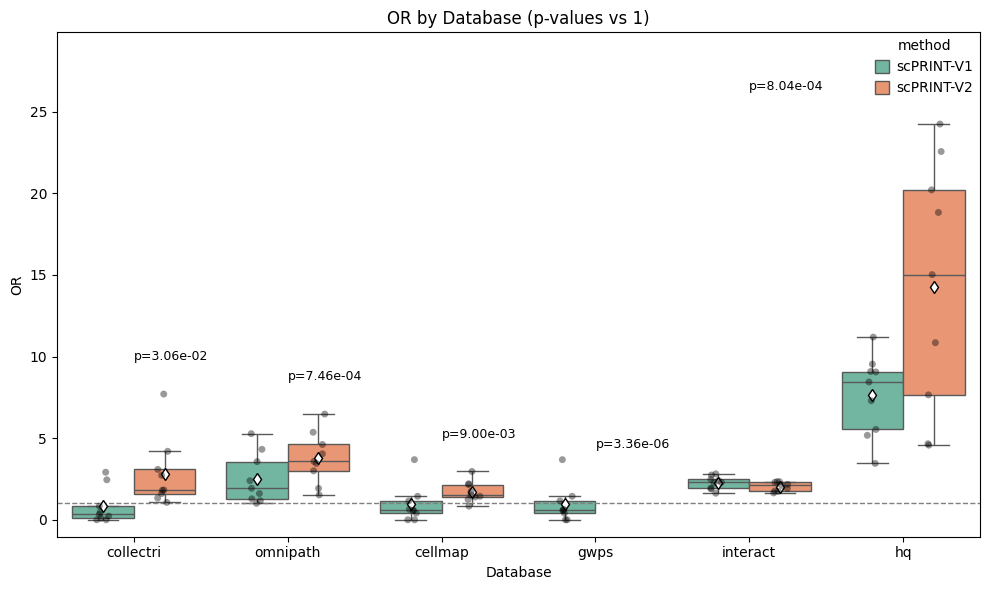

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp

plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=df_long,
    x="Database",
    y="OR",
    hue="method",
    fliersize=0,
    palette="Set2",
    showmeans=True,
    meanprops={"marker": "d", "markerfacecolor": "white", "markeredgecolor": "black"},
)
sns.stripplot(
    data=df_long,
    x="Database",
    y="OR",
    hue="method",
    palette=["black", "black"],  # Use black for both methods
    dodge=True,  # This aligns the strips with the boxplot groups
    alpha=0.4,
    size=5,
    legend=False,  # Avoid duplicate legend entries
)
# Reference line at 1
ax.axhline(1, ls="--", c="gray", lw=1)

# Compute and annotate p-values (one-sample test vs 0)
max_y = df_long2["OR"].max()
min_y = df_long2["OR"].min()
span = max(max_y - min_y, 1e-6)
offset = 0.08 * span

for i, col in enumerate(df.columns):
    x = df[col].dropna().values
    stat, p = ttest_1samp(x, 1.0, nan_policy="omit")
    y = df[col].max() + offset
    ax.text(i, y, f"p={p:.2e}", ha="left", va="bottom", fontsize=9)

ax.set_ylim(min_y - offset, max_y + 3 * offset)
plt.title("OR by Database (p-values vs 1)")
plt.xlabel("Database")
plt.ylabel("OR")
plt.tight_layout()
plt.show()

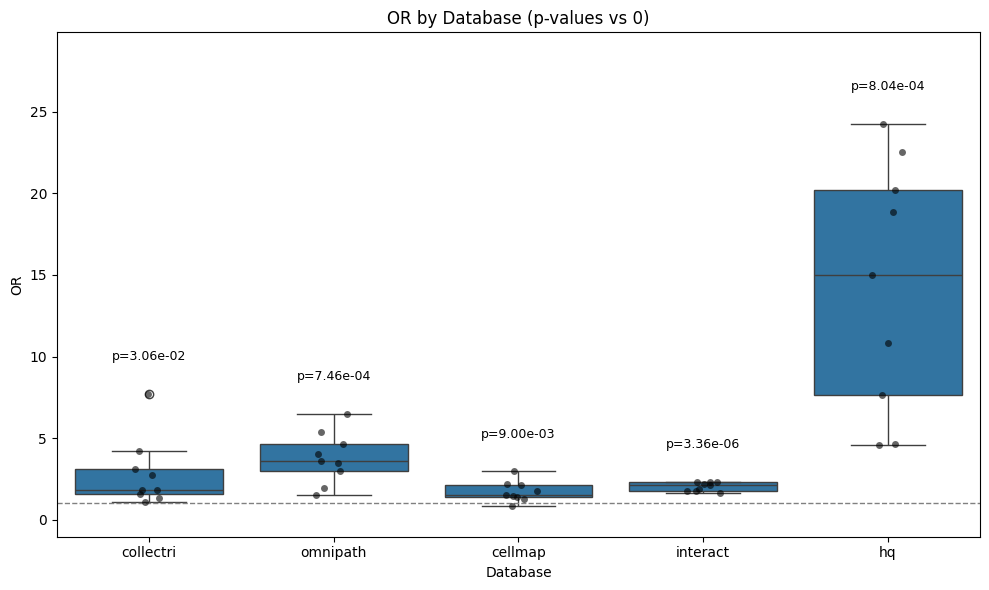

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp

df = pd.DataFrame(
    {i: v for i, v in show.items() if "_odd_ratio" in i},
    index=[
        "Loop of Henle",
        "Epithelial cell",
        "Intercalated cell",
        "Endothelial cell (APC)",
        "Monocyte",
        "Macrophage",
        "Smooth muscle cell",
        "Dendritic cell",
        "Sinusoidal endothelial cell",
    ],
)

# Clean column names (remove '_auprc' suffix)
df.columns = [col.replace("_odd_ratio", "") for col in df.columns]

# Long format for seaborn
df_long = df.reset_index().melt(id_vars="index", var_name="Database", value_name="OR")
df_long = df_long.rename(columns={"index": "Cell Type"})

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_long, x="Database", y="OR")
sns.stripplot(data=df_long, x="Database", y="OR", color="k", alpha=0.6, size=5)

# Reference line at 1
ax.axhline(1, ls="--", c="gray", lw=1)

# Compute and annotate p-values (one-sample test vs 0)
max_y = df_long["OR"].max()
min_y = df_long["OR"].min()
span = max(max_y - min_y, 1e-6)
offset = 0.08 * span

for i, col in enumerate(df.columns):
    x = df[col].dropna().values
    stat, p = ttest_1samp(x, 1.0, nan_policy="omit")
    y = df[col].max() + offset
    ax.text(i, y, f"p={p:.2e}", ha="center", va="bottom", fontsize=9)

ax.set_ylim(min_y - offset, max_y + 3 * offset)
plt.title("OR by Database (p-values vs 1)")
plt.xlabel("Database")
plt.ylabel("OR")
plt.tight_layout()
plt.show()

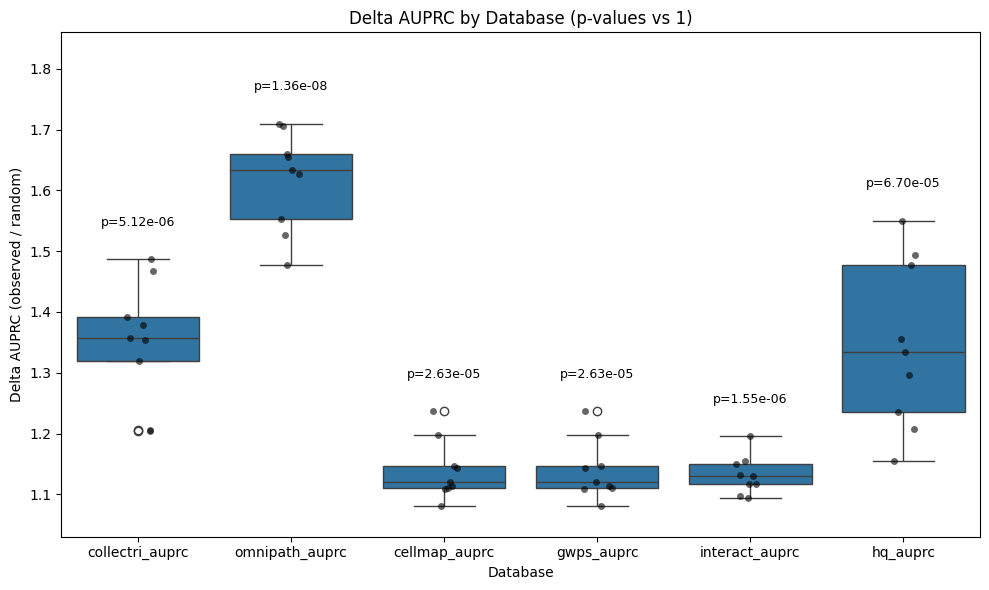

In [42]:
df = pd.DataFrame(
    {i: v for i, v in show.items() if "_auprc" in i},
    index=[
        "Loop of Henle",
        "Epithelial cell",
        "Intercalated cell",
        "Endothelial cell (APC)",
        "Monocyte",
        "Macrophage",
        "Smooth muscle cell",
        "Dendritic cell",
        "Sinusoidal endothelial cell",
    ],
)

# Long format for seaborn
df_long = df.reset_index().melt(
    id_vars="index", var_name="Database", value_name="DeltaAUPRC"
)
df_long = df_long.rename(columns={"index": "Cell Type"})

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_long, x="Database", y="DeltaAUPRC")
sns.stripplot(data=df_long, x="Database", y="DeltaAUPRC", color="k", alpha=0.6, size=5)

# Reference line at 1
ax.axhline(1, ls="--", c="gray", lw=1)

# Compute and annotate p-values (one-sample test vs 0)
max_y = df_long["DeltaAUPRC"].max()
min_y = df_long["DeltaAUPRC"].min()
span = max(max_y - min_y, 1e-6)
offset = 0.08 * span

for i, col in enumerate(df.columns):
    x = df[col].dropna().values
    stat, p = ttest_1samp(x, 1.0, nan_policy="omit")
    y = df[col].max() + offset
    ax.text(i, y, f"p={p:.2e}", ha="center", va="bottom", fontsize=9)

ax.set_ylim(min_y - offset, max_y + 3 * offset)
plt.title("Delta AUPRC by Database (p-values vs 1)")
plt.xlabel("Database")
plt.ylabel("Delta AUPRC (observed / random)")
plt.tight_layout()
plt.show()

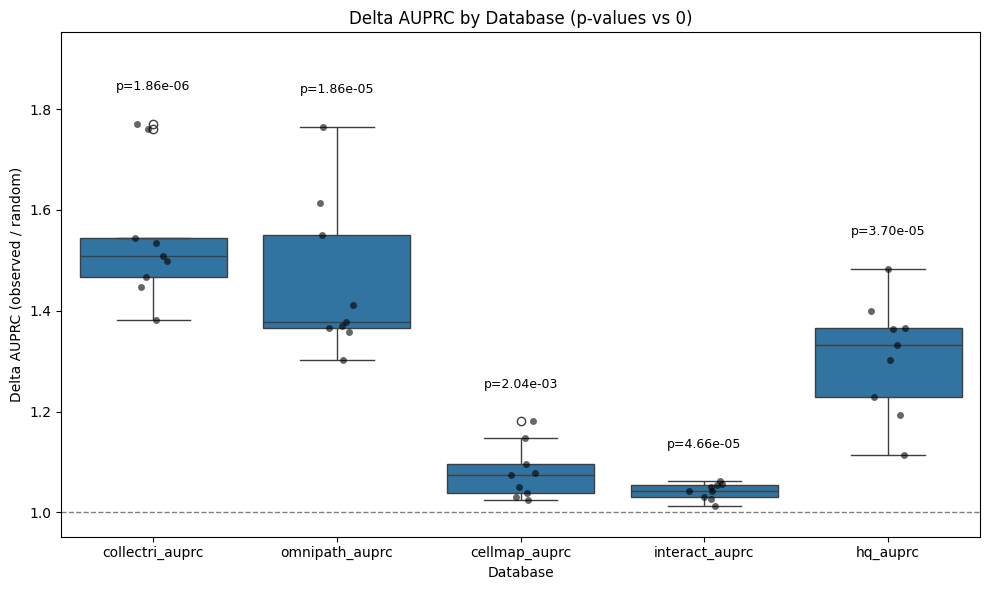

In [ ]:
df = pd.DataFrame(
    {i: v for i, v in show.items() if "_auprc" in i},
    index=[
        "Loop of Henle",
        "Epithelial cell",
        "Intercalated cell",
        "Endothelial cell (APC)",
        "Monocyte",
        "Macrophage",
        "Smooth muscle cell",
        "Dendritic cell",
        "Sinusoidal endothelial cell",
    ],
)

# Long format for seaborn
df_long = df.reset_index().melt(
    id_vars="index", var_name="Database", value_name="DeltaAUPRC"
)
df_long = df_long.rename(columns={"index": "Cell Type"})

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_long, x="Database", y="DeltaAUPRC")
sns.stripplot(data=df_long, x="Database", y="DeltaAUPRC", color="k", alpha=0.6, size=5)

# Reference line at 1
ax.axhline(1, ls="--", c="gray", lw=1)

# Compute and annotate p-values (one-sample test vs 0)
max_y = df_long["DeltaAUPRC"].max()
min_y = df_long["DeltaAUPRC"].min()
span = max(max_y - min_y, 1e-6)
offset = 0.08 * span

for i, col in enumerate(df.columns):
    x = df[col].dropna().values
    stat, p = ttest_1samp(x, 1.0, nan_policy="omit")
    y = df[col].max() + offset
    ax.text(i, y, f"p={p:.2e}", ha="center", va="bottom", fontsize=9)

ax.set_ylim(min_y - offset, max_y + 3 * offset)
plt.title("Delta AUPRC by Database (p-values vs 1)")
plt.xlabel("Database")
plt.ylabel("Delta AUPRC (observed / random)")
plt.tight_layout()
plt.show()